In [1]:
#%% Import
import sys
sys.path.append("/home/jan/Documents/ETH/Masterarbeit/climada_python")
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import geopandas as gpd
from climada.hazard import Hazard
from scipy import sparse
import copy as cp
from matplotlib import pyplot as plt
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import h5py
import hail_functions as fct
from sklearn.metrics import mean_squared_error
from scipy import optimize
import time
from scipy import stats
from scipy.stats import spearmanr


2021-03-28 16:24:03,996 - climada - DEBUG - Loading default config file: /home/jan/Documents/ETH/Masterarbeit/climada_python/climada/conf/defaults.conf


/home/jan/anaconda3/envs/climada_hail/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#%% Parameter
# If any value in force_new_hdf5_generation is True the script will ask for 
# user input wether to overwrite the hdf5 with the new data
force_new_hdf5_generation ={"haz_real": False, 
                            "haz_synth": False, 
                            "haz_dur": False,
                            "exp_infr": False, 
                            "exp_agr": False}
name_hdf5_file={"haz_real": "haz_real.hdf5", 
                "haz_synth": "haz_synth.hdf5", 
                "haz_dur": "haz_dur.hdf5",
                "exp_infr": "exp_switzerland.hdf5", 
                "exp_agr": "exp_agr.hdf5"}

# Optimization
optimize_type = "" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
plot_img = False
haz_type = "HL"
ev_list = ["12/07/2011", "13/07/2011"]#["01/07/2019", "02/07/2019", "18/08/2019", "06/08/2019", "30/06/2019", "15/06/2019"]#, "01/07/2019", "18/06/2019"]
start_day = 0 #min = 0
end_day = 183 #max = 183
# imp_fun_infrastructure = {"imp_id": 1, "L": 0.1, "x_0": 100, "k": 10}
# imp_fun_grape = {"imp_id": 2, "L": 0.8, "x_0": 35, "k": 10}
# imp_fun_fruit = {"imp_id": 3, "L": 1.0, "x_0": 80, "k": 10}
# imp_fun_agriculture = {"imp_id": 4, "L": 0.5, "x_0": 50, "k": 10}
# imp_fun_dur_grape = {"imp_id": 5, "L": 0.8, "x_0": 50, "k": 1}
# imp_fun_dur_fruit = {"imp_id": 6, "L": 1.0, "x_0": 50, "k": 1}
# imp_fun_dur_agriculture = {"imp_id": 7, "L": 0.5, "x_0": 50, "k": 1}
imp_fun_infrastructure = {"imp_id": 1, "L": 0.08, "x_0": 100, "k": 5}
imp_fun_grape = {"imp_id": 2, "L": 0.39, "x_0": 47, "k": 40}
imp_fun_fruit = {"imp_id": 3, "L": 0.88, "x_0": 67, "k": 18}
imp_fun_agriculture = {"imp_id": 4, "L": 0.89, "x_0": 199, "k": 32}
imp_fun_dur_grape = {"imp_id": 5, "L": 0.73, "x_0": 11, "k": 38}
imp_fun_dur_fruit = {"imp_id": 6, "L": 0.29, "x_0": 120, "k": 0}
imp_fun_dur_agriculture = {"imp_id": 7, "L": 0.94, "x_0": 128, "k": 31}

imp_fun_parameter = [imp_fun_infrastructure,
                     imp_fun_grape,
                     imp_fun_fruit,
                     imp_fun_agriculture,
                     imp_fun_dur_grape, 
                     imp_fun_dur_fruit, 
                     imp_fun_dur_agriculture]
# Path to Data 
input_folder = "/home/jan/Documents/ETH/Masterarbeit/input"
results_folder = "~/Documents/ETH/Masterarbeit/results"
years =["2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]
years_synth = ["1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001" ,"2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]


In [3]:
#%% Hazard
haz_real = fct.load_haz(force_new_hdf5_generation, "haz_real", name_hdf5_file, input_folder, years)
haz_synth = fct.load_haz(force_new_hdf5_generation, "haz_synth", name_hdf5_file, input_folder, years_synth)
haz_dur = fct.load_haz(force_new_hdf5_generation, "haz_dur", name_hdf5_file, input_folder, years)

haz_real.check()
haz_synth.check()

if plot_img:
    haz_real.plot_intensity(event = 0)
    haz_real.plot_fraction(event = 0)

2021-03-28 16:24:06,995 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_real.hdf5
2021-03-28 16:24:07,248 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_synth.hdf5
2021-03-28 16:24:07,387 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_dur.hdf5


2021-03-28 16:24:07,635 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:07,637 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:07,639 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:07,641 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:07,642 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f218f3d36d0>,
      dtype=object)

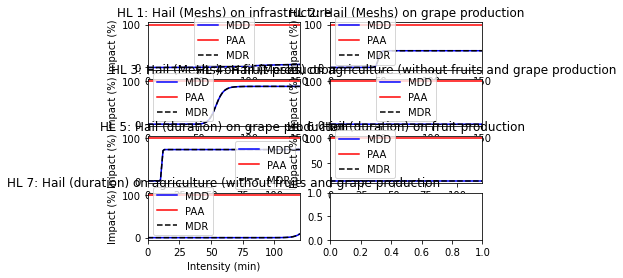

In [4]:
#%% Impact_function
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()
for imp_fun_dict in imp_fun_parameter:
    imp_fun = fct.create_impact_func(haz_type, 
                                 imp_fun_dict["imp_id"], 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    ifset_hail.append(imp_fun)
ifset_hail.plot()

2021-03-28 16:24:08,646 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:08,648 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:08,650 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:08,654 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:08,656 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21856500d0>,
      dtype=object)

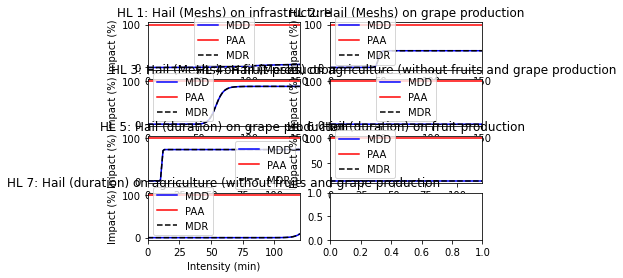

In [5]:
#%% Impact_function
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()
for imp_fun_dict in imp_fun_parameter:
    imp_fun = fct.create_impact_func(haz_type, 
                                 imp_fun_dict["imp_id"], 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    ifset_hail.append(imp_fun)
ifset_hail.plot()

In [6]:
#%% Exposure

exp_infr = fct.load_exp_infr(force_new_hdf5_generation, name_hdf5_file, input_folder, haz_real)
exp_agr = fct.load_exp_agr(force_new_hdf5_generation, name_hdf5_file, input_folder, haz_real)
exp_dur = exp_agr.copy()
exp_dur["if_HL"] = exp_dur["if_HL"]+3 #change if_HL to match the corresponding imp_id
if plot_img:    
    exp_infr.plot_basemap()
    #This takes to long. Do over night!!!
    #exp_agr.plot_basemap() 


2021-03-28 16:24:09,591 - climada.entity.exposures.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/exp_switzerland.hdf5
2021-03-28 16:24:10,122 - climada.entity.exposures.base - INFO - deductible not set.
2021-03-28 16:24:10,123 - climada.entity.exposures.base - INFO - cover not set.
2021-03-28 16:24:10,124 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-28 16:24:10,126 - climada.entity.exposures.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/exp_agr.hdf5
2021-03-28 16:24:10,224 - climada.entity.exposures.base - INFO - deductible not set.
2021-03-28 16:24:10,224 - climada.entity.exposures.base - INFO - cover not set.
2021-03-28 16:24:10,225 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-28 16:24:10,226 - climada.entity.exposures.base - INFO - geometry not set.


2021-03-28 16:24:10,255 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:10,259 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


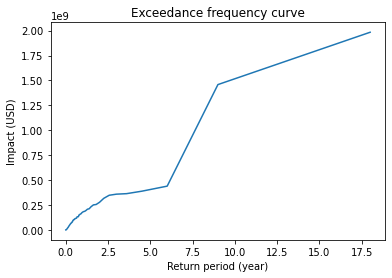

2021-03-28 16:24:11,360 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:11,368 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


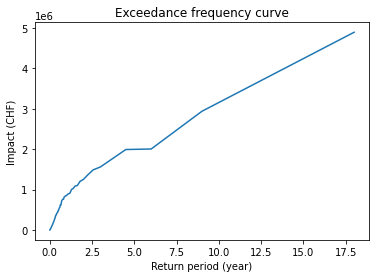

2021-03-28 16:24:19,386 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:19,396 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


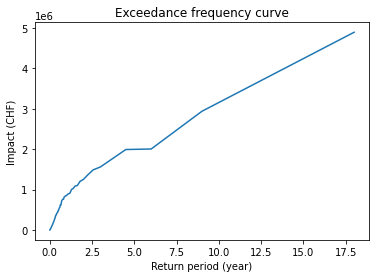

In [7]:
#%% Impact

imp_infr = Impact()
imp_infr.calc(exp_infr, ifset_hail, haz_real,save_mat=True)
# imp_infr.plot_raster_eai_exposure()
freq_curve_infr = imp_infr.calc_freq_curve()
freq_curve_infr.plot()
plt.show()

imp_agr = Impact()
imp_agr.calc(exp_agr, ifset_hail, haz_real, save_mat = True)
freq_curve_agr = imp_agr.calc_freq_curve()
freq_curve_agr.plot()
plt.show()

imp_agr_dur = Impact()
imp_agr_dur.calc(exp_dur, ifset_hail, haz_dur, save_mat = True)
freq_curve_agr = imp_agr.calc_freq_curve()
freq_curve_agr.plot()
plt.show()

return_period = cp.copy(freq_curve_infr.return_per)


dmg infr 1014.320324045909 Mio CHF, dmg agr_meshs 4.249118697566551 Mio CHF, dmg agr_dur 59.42210565680223 Mio CHF


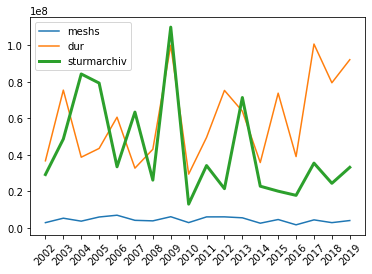

pearson for agr with meshs (score, p_value) = (0.4421997166837591, 0.06614113384110695) 
pearson for agr with dur (score, p_value) = (0.16464121779523178, 0.5138563120710609) 
spearman for agr with meshs (score, p_value) = (0.479876160990712, 0.04386464036882083)
spearman for agr with dur (score, p_value) = (0.23839009287925697, 0.340779724454077)


In [8]:
#just some stuff
print("dmg infr {} Mio CHF, dmg agr_meshs {} Mio CHF, dmg agr_dur {} Mio CHF".format(imp_infr.aai_agg/1e6, imp_agr.aai_agg/1e6, imp_agr_dur.aai_agg/1e6))
agr_meshs_yearly_imp = list(imp_agr.calc_impact_year_set(year_range = [2002, 2019]).values())
agr_dur_yearly_imp = list(imp_agr_dur.calc_impact_year_set(year_range = [2002, 2019]).values())
# plt.figure()
# plt.bar(years, agr_dur_yearly_imp)
# plt.show()
# plt.figure()
# plt.bar(years, agr_meshs_yearly_imp)
dmg_from_sturmarchiv = [29.12, 48.61, 84.34, 79.35, 33.37, 63.40, 26.05, 110.06, 12.87, 34.05, 21.35, 71.41, 22.71, 19.98, 17.69, 35.39, 24.30, 33.07]
dmg_from_sturmarchiv_complet = [23.1, 24.1, 13.8, 11.7, 18.4, 43.4, 30.1, 29.0, 36.7, 20.2, 56.8, 43.3, 28.2, 37.1, 66.2, 28.8, 57.5, 38.7, 43.8, 68.7, 66.4, 69.9, 116, 34.1, 40.3, 40.6, 35.0, 107, 84.5, 24.7 ,  29.12, 48.61, 84.34, 79.35, 33.37, 63.40, 26.05, 110.06, 12.87, 34.05, 21.35, 71.41, 22.71, 19.98, 17.69, 35.39, 24.30, 33.07]
dmg_from_sturmarchiv = [int(i*1e6) for i in dmg_from_sturmarchiv]
dmg_from_sturmarchiv_complet = [int(i*1e6) for i in dmg_from_sturmarchiv_complet]

dmg_from_vkg = [164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50, 16.55]
dmg_from_vkg = [i*1e6 for i in dmg_from_vkg]
norm_agr_meshs_yearly_imp = np.divide(agr_meshs_yearly_imp, min(agr_meshs_yearly_imp))
norm_agr_dur_yearly_imp = np.divide(agr_dur_yearly_imp, min(agr_dur_yearly_imp))
norm_dmg_from_sturmarchiv = np.divide(dmg_from_sturmarchiv, min(dmg_from_sturmarchiv)) #[i / min(dmg_from_sturmarchiv) for i in dmg_from_sturmarchiv]

#plot
plt.figure()
plt.plot(years, agr_meshs_yearly_imp)
plt.plot(agr_dur_yearly_imp)
plt.plot(dmg_from_sturmarchiv, linewidth = 3)
plt.legend(["meshs", "dur", "sturmarchiv"])
plt.xticks(rotation = 45)
plt.show()

print("pearson for agr with meshs (score, p_value) = {} ".format(stats.pearsonr(norm_dmg_from_sturmarchiv, norm_agr_meshs_yearly_imp)))
print("pearson for agr with dur (score, p_value) = {} ".format(stats.pearsonr(norm_dmg_from_sturmarchiv, norm_agr_dur_yearly_imp)))

coef, p_value = spearmanr(norm_dmg_from_sturmarchiv, norm_agr_meshs_yearly_imp)    
print("spearman for agr with meshs (score, p_value) = ({}, {})".format(coef, p_value))
coef, p_value = spearmanr(norm_dmg_from_sturmarchiv, norm_agr_dur_yearly_imp)    
print("spearman for agr with dur (score, p_value) = ({}, {})".format(coef, p_value))

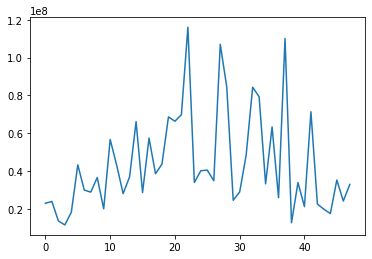

In [9]:
plt.plot(dmg_from_sturmarchiv_complet)

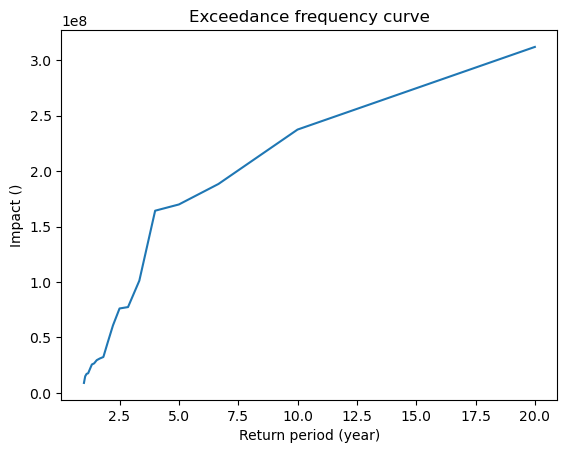

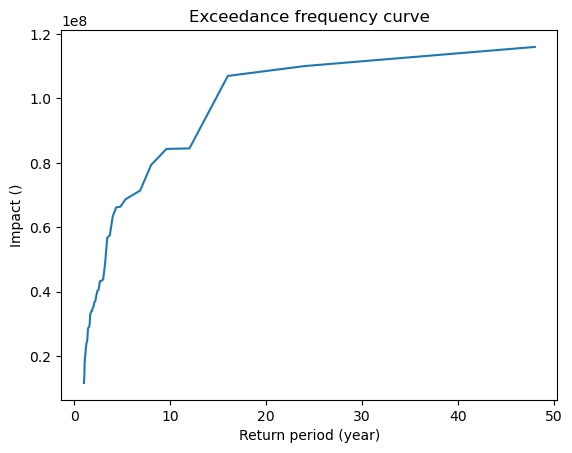

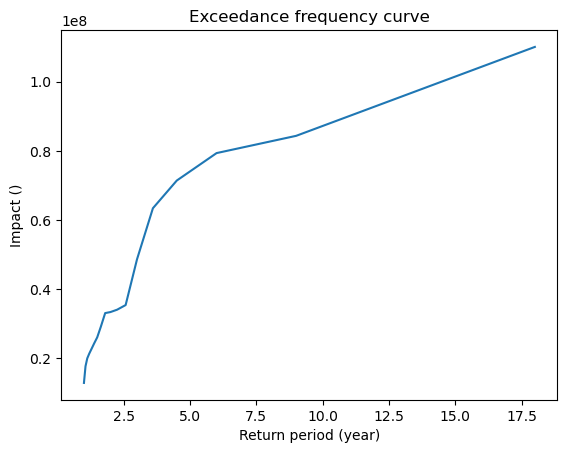

In [10]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
vkg_data = [45.36, 77.37, 21.39, 164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50]
vkg_data = [int(i*1e6) for i in vkg_data] 
imp_vkg = Impact()
imp_vkg.at_event = np.asarray(vkg_data)
imp_vkg.frequency = np.ones(len(imp_vkg.at_event))/len(imp_vkg.at_event)
imp_vkg_freq_curve_org = imp_vkg.calc_freq_curve()
imp_vkg_freq_curve_org.plot()

imp_sturm_complet = Impact()
imp_sturm_complet.at_event = np.asarray(dmg_from_sturmarchiv_complet)
imp_sturm_complet.frequency = np.ones(len(imp_sturm_complet.at_event))/len(imp_sturm_complet.at_event)
imp_sturm_complet_freq_curve_org = imp_sturm_complet.calc_freq_curve()
imp_sturm_complet_freq_curve_org.plot()

imp_sturm = Impact()
imp_sturm.at_event = np.asarray(dmg_from_sturmarchiv)
imp_sturm.frequency = np.ones(len(imp_sturm.at_event))/len(imp_sturm.at_event)
imp_sturm_freq_curve_org = imp_sturm.calc_freq_curve()
imp_sturm_freq_curve_org.plot()


return_period_org = cp.copy(imp_vkg_freq_curve_org.return_per)


return_per = return_period

In [11]:
#get the right return period
return_period = cp.copy(return_period_org)
x1 = return_period[0]
x2 = return_period[-1]
print(return_period_org)
for count, i in enumerate(return_period):
    return_period[count] = i - cp.copy((2/(x2-x1)) * i - (2*x1/(x2-x1)))
print(return_period)

[ 1.          1.05263158  1.11111111  1.17647059  1.25        1.33333333
  1.42857143  1.53846154  1.66666667  1.81818182  2.          2.22222222
  2.5         2.85714286  3.33333333  4.          5.          6.66666667
 10.         20.        ]
[ 1.          1.04709141  1.0994152   1.15789474  1.22368421  1.29824561
  1.38345865  1.48178138  1.59649123  1.73205742  1.89473684  2.09356725
  2.34210526  2.66165414  3.0877193   3.68421053  4.57894737  6.07017544
  9.05263158 18.        ]


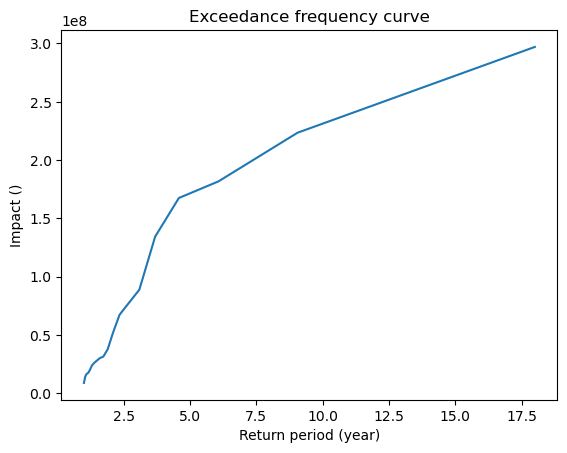

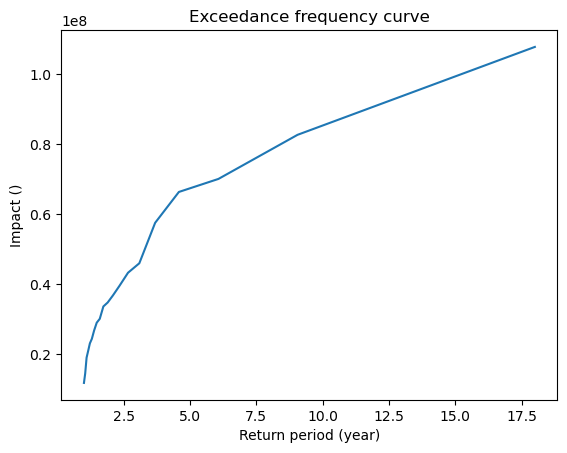

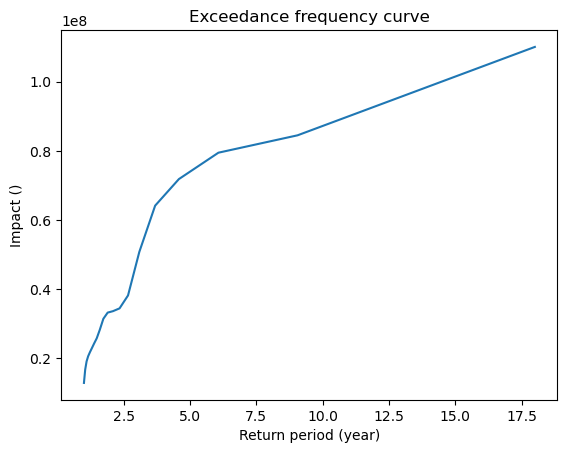

In [12]:
imp_vkg_freq_curve = imp_vkg.calc_freq_curve(return_per = cp.copy(return_period))
imp_vkg_freq_curve.plot()

imp_sturm_complet_freq_curve = imp_sturm_complet.calc_freq_curve(return_per = cp.copy(return_period))
imp_sturm_complet_freq_curve.plot()

imp_sturm_freq_curve = imp_sturm.calc_freq_curve(return_per = cp.copy(return_period))
imp_sturm_freq_curve.plot()


In [13]:
imp_vkg_freq_curve.impact

array([8.98000000e+06, 1.43305263e+07, 1.67120000e+07, 1.75150526e+07,
       2.00550526e+07, 2.38273684e+07, 2.61263158e+07, 2.80042105e+07,
       3.01789474e+07, 3.15826316e+07, 3.78278947e+07, 5.18610526e+07,
       6.74117895e+07, 7.66857895e+07, 8.88990526e+07, 1.34385263e+08,
       1.67529474e+08, 1.81759684e+08, 2.23486632e+08, 2.97054000e+08])

In [14]:
Optimization_results = []
def create_dict(*args):
  return dict({i:eval(i) for i in args})

In [15]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [16]:
def spearmanr_ci(x, y, alpha=0.05):
    r, p = stats.spearmanr(x, y)
    r_z = np.arctanh(r)
    se = np.sqrt((1+r**2/2)/(x.size-3))
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# First Result

Lets first start with infrastructure and a constant imp_fun. So when there is a hail event in the data (POH=1 and MESHS > 2cm) there will be a constant damage

In [17]:
#%% Optimization
if False:
    optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
    sector = "infr" # ["infr", "agr"]
    optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
    score_type = "RMSF" #["pearson", "spearman", "RMSF"]
    type_imp_fun = "const" #["sig", "lin", "class", "const"]
    norm = False
    class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
    bound = [(0.1,1),(1.0,150),(0.0,20)]
    if optimize_type != "":
        num_fct = 1 #[1:3]
        init_parameter=[]
        if sector == "agr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[1:1+num_fct]
                haz = haz_real
                exp = exp_meshs.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                parameter_optimize = imp_fun_parameter[4:4+num_fct]
                haz = haz_dur
                bounds = num_fct*bound
                exp = exp_dur.copy()
        elif sector=="infr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[0:1+num_fct]
                haz = haz_real
                exp = exp_infr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                print("NO dur for infr")

        for i in range(num_fct):
            init_parameter += [*parameter_optimize[i].values()][1:4]

        if num_fct == 1:
            exp["if_HL"] = parameter_optimize[0]["imp_id"]
        if type_imp_fun == "lin":
            bounds = [(0.01,0.03)]
            imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
            parameter_optimize = [imp_fun_lin]
            exp.if_HL = 9
        if type_imp_fun == "class":
            bound = [(0,0.001)]
            if class_mult:
                bounds = [slice(0,0.000_051,0.000_01),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2)]
            else:
                bounds = [slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,0.01_1,0.000_1)]                
            init_parameter = [0,0,0,0]
            parameter_optimize=init_parameter
        if type_imp_fun == "const":
            parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
            bounds = [slice(0.000_000,0.001_0,0.000_001)]
        args = (parameter_optimize, 
                exp, 
                haz, 
                haz_type, 
                num_fct, 
                score_type, 
                type_imp_fun, 
                sector, 
                norm, 
                class_mult,
                optimize_type)
        # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
        optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
        # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
        # test = fct.make_Y(init_parameter, args)
        print(optimize_results)
        print(score_type)
        print(optimize_type)


    Optimization_results.append(create_dict("sector", 
                                            "optimize_type", 
                                            "score_type", 
                                            "type_imp_fun", 
                                            "norm", 
                                            "class_mult", 
                                            "num_fct", 
                                            "bounds", 
                                            "optimize_results"))


Lets look at all "usefull" results,
{'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(5e-05, 0.0001, 1e-06)],
  'optimize_results': 5.5999999999999986e-05}
  
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSE',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.001, 1e-06)],
  'optimize_results': 8.999999999999999e-05}]

and visualize them in the next panel

2021-03-28 16:24:31,932 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:31,934 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:31,942 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 52424149.9582802
Correlation of the RMSF data for spearman is 0.4262125902992776 with upper limit 0.7547074102931423 and lower limit -0.07315321008405272 with p value of 0.07778293683965698
Correlation of the RMSF data for pearson is 0.30634414117487063 with upper limit 0.6764643183279397 and lower limit -0.18731648101911597 with a p value of 0.2163118176073351
RMSF is 2.58819011604362


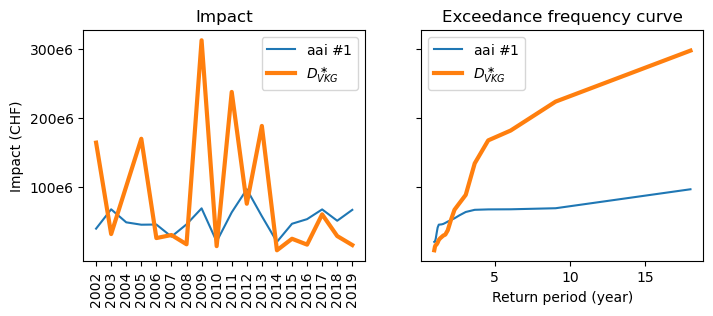

In [18]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib

y = np.zeros(150)
y[:] = 5.6e-05
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))

#plot

plt.rcParams['figure.figsize'] = [8, 3]
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0].plot(dmg_from_vkg, linewidth = 3)
axs[0].legend([r"aai $\# 1$", r"$D_{VKG}^\ast$"])


axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel("Impact (CHF)")
axs[0].set_yticks(ticks=[100e6, 200e6, 300e6])
axs[0].set_yticklabels(labels=["100e6","200e6","300e6"])
axs[0].set_title("Impact")
#freq_curve = imp_RMSF.calc_freq_curve(return_per = cp.copy(return_period)) every day is an event in this set
#therefore we switch it up so the freq curve takes aai as event

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)


imp_RMSF_year_freq_curve.unit = "CHF"
imp_RMSF_year_freq_curve.plot(axis=axs[1])
imp_vkg_freq_curve.plot(axis=axs[1], linewidth = 3)
axs[1].legend([r"aai $\# 1$", r"$D_{VKG}^\ast$"])
axs[1].set_ylabel("")

matplotlib.rcParams.update(matplotlib.rcParamsDefault)



Coefficients: 
 [[1.48635945]]
Mean squared error: 1140750261250523.75
Coefficient of determination: -2.45


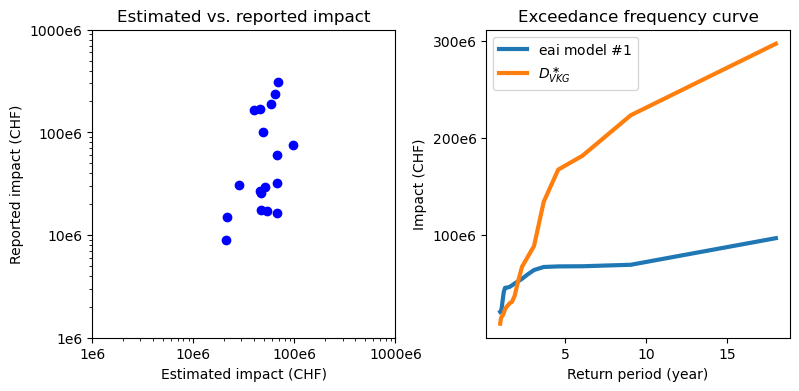

In [19]:
plt.rcParams['figure.figsize'] = [9, 4]


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.ticker
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
#plt.plot(X,y_pred)


fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])
imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3)
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3)
ax[1].legend([r"eai model $\# 1$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [20]:
imp_fun_list = np.arange(1, 150, 1)
dmg_for_imp_list = []


for i in imp_fun_list:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 1, 
                                 0, 
                                 0, 
                                 0)
    imp_fun.mdd[:] = 0
    imp_fun.mdd[i] = 5.6e-05
    ifset_hail.append(imp_fun)
    imp_infr_meshs = Impact()
    imp_infr_meshs.calc(exp_infr, ifset_hail, haz_real,save_mat=False)
    dmg_for_imp_list.append(imp_infr_meshs.aai_agg/1e6)


2021-03-28 16:24:34,043 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:34,045 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:34,049 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:34,201 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:34,202 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:34,206 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


/home/jan/Documents/ETH/Masterarbeit/climada_hail_script/hail_functions.py:494: RuntimeWarning: invalid value encountered in long_scalars
  f_x = max(i2-x_min,0)/(x_0-x_min)
/home/jan/Documents/ETH/Masterarbeit/climada_hail_script/hail_functions.py:494: RuntimeWarning: divide by zero encountered in long_scalars
  f_x = max(i2-x_min,0)/(x_0-x_min)


2021-03-28 16:24:34,363 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:34,364 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:34,368 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:34,527 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:34,528 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:34,531 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:34,682 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-03-28 16:24:37,364 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:37,367 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:37,524 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:37,528 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:37,539 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:37,688 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:37,689 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28

2021-03-28 16:24:40,497 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:40,498 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:40,500 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:40,676 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:40,677 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:40,679 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:40,848 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-03-28 16:24:43,542 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:43,549 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:43,701 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:43,702 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:43,705 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:43,843 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:43,844 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28

2021-03-28 16:24:46,389 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:46,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:46,393 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:46,550 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:46,551 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:46,554 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:46,697 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-03-28 16:24:49,136 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:49,139 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:49,303 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:49,304 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:49,307 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:49,456 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:49,457 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28

2021-03-28 16:24:52,189 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:52,190 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:52,193 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:52,343 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:52,344 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:52,348 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:52,532 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-03-28 16:24:54,865 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:54,868 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:55,003 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:55,004 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:55,009 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 16:24:55,151 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:55,152 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28

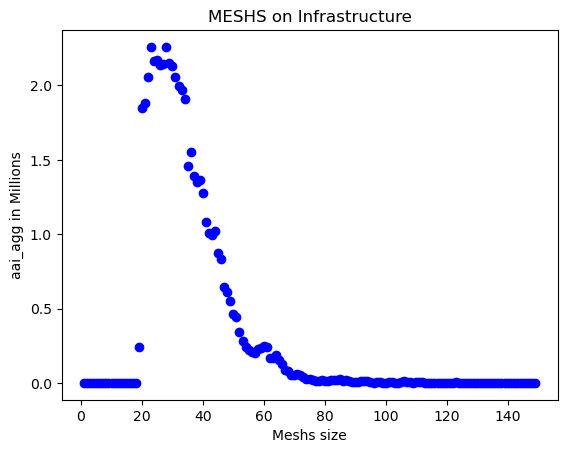

In [21]:
plt.plot(imp_fun_list, dmg_for_imp_list, "bo")
plt.xlabel("Meshs size")
plt.ylabel("aai_agg in Millions")
plt.title("MESHS on Infrastructure")
plt.show()

Lets do the same with Agriculture

In [22]:
#%% Optimization
if False:
    optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
    sector = "agr" # ["infr", "agr"]
    optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
    score_type = "RMSF" #["pearson", "spearman", "RMSF"]
    type_imp_fun = "const" #["sig", "lin", "class", "const"]
    norm = False
    class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
    bound = [(0.1,1),(1.0,150),(0.0,20)]
    if optimize_type != "":
        num_fct = 1 #[1:3]
        init_parameter=[]
        if sector == "agr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[1:1+num_fct]
                haz = haz_real
                exp = exp_agr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                parameter_optimize = imp_fun_parameter[4:4+num_fct]
                haz = haz_dur
                bounds = num_fct*bound
                exp = exp_dur.copy()
        elif sector=="infr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[0:1+num_fct]
                haz = haz_real
                exp = exp_infr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                print("NO dur for infr")

        for i in range(num_fct):
            init_parameter += [*parameter_optimize[i].values()][1:4]

        if num_fct == 1:
            exp["if_HL"] = parameter_optimize[0]["imp_id"]
        if type_imp_fun == "lin":
            bounds = [(0.01,0.03)]
            imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
            parameter_optimize = [imp_fun_lin]
            exp.if_HL = 9
        if type_imp_fun == "class":
            bound = [(0,0.001)]
            if class_mult:
                bounds = [slice(0,0.000_051,0.000_01),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2)]
            else:
                bounds = [slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,0.01_1,0.000_1)]                
            init_parameter = [0,0,0,0]
            parameter_optimize=init_parameter
        if type_imp_fun == "const":
            parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
            bounds = [slice(0.000_000,0.200_0,0.001_0)]
        args = (parameter_optimize, 
                exp, 
                haz, 
                haz_type, 
                num_fct, 
                score_type, 
                type_imp_fun, 
                sector, 
                norm, 
                class_mult,
                optimize_type)
        # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
        optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
        # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
        # test = fct.make_Y(init_parameter, args)
        print(optimize_results)
        print(score_type)
        print(optimize_type)


    Optimization_results.append(create_dict("sector", 
                                            "optimize_type", 
                                            "score_type", 
                                            "type_imp_fun", 
                                            "norm", 
                                            "class_mult", 
                                            "num_fct", 
                                            "bounds", 
                                            "optimize_results"))


Lets look at the usefull results:

 {'sector': 'agr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.2, 0.002)],
  'optimize_results': 0.022},
 
 
 {'sector': 'agr',
  'optimize_type': 'meshs',
  'score_type': 'RMSE',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0.0, 0.2, 0.002)],
  'optimize_results': 0.024}]
  

2021-03-28 16:24:57,806 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:24:57,813 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:24:57,823 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


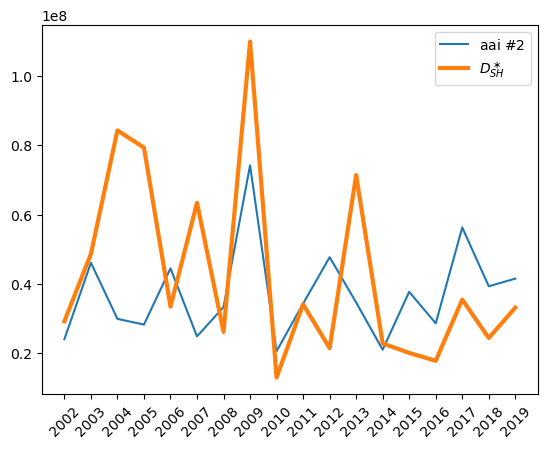

aai_agg = 36981259.34943567
RMSF is 1.7724440689865437
Correlation of the RMSF data for spearman is 0.2714138286893705 with upper limit 0.6604917997016324 and lower limit -0.23257177786524544 with p value of 0.27595238461589006
Correlation of the RMSF data for pearson is 0.37365394559579873 with upper limit 0.7156759006022879 and lower limit -0.11291367542337652 with a p value of 0.12665691648113725
RMSF is 2.8943086305682075


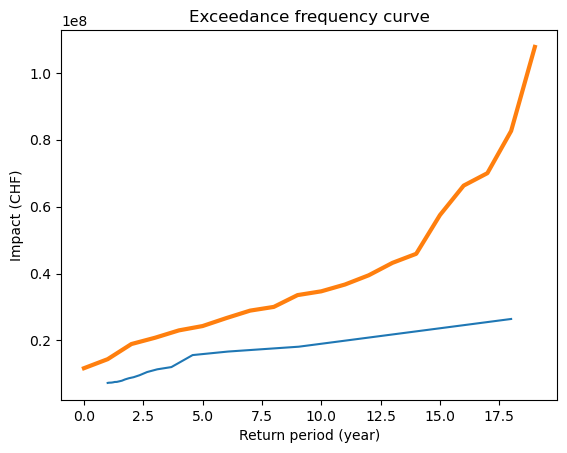

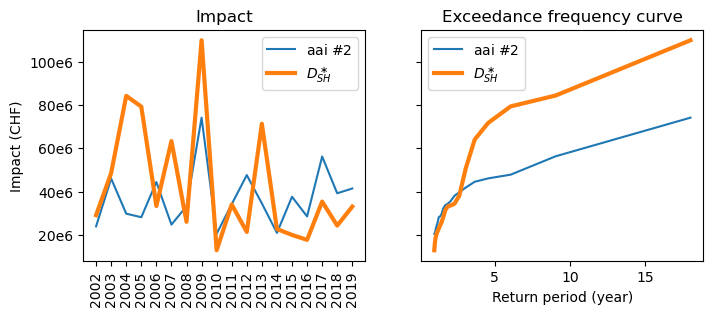

In [23]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

y = np.zeros(150)
y[:] = 0.022
exp_agr["if_HL"]=10
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         10,
                                         0,
                                         0,
                                         0,
                                         y))

imp_agr_RMSF = Impact()
imp_agr_RMSF.calc(exp_agr, ifset_hail, haz_real, save_mat=True)

#plot
plt.figure()
plt.plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_sturmarchiv, linewidth = 3)
plt.legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
plt.xticks(rotation = 45)
plt.show()

Y_RMSF = list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())


print("aai_agg = {}".format(imp_agr_RMSF.aai_agg))

print("RMSF is {}".format(fct.RMSF(dmg_from_sturmarchiv, Y_RMSF)))

spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))

freq_curve = imp_agr_RMSF.calc_freq_curve(return_per = cp.copy(return_period))
freq_curve.unit = "CHF"
freq_curve.plot()
plt.plot(imp_sturm_complet_freq_curve.impact, linewidth = 3)

plt.rcParams['figure.figsize'] = [8, 3]
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0].plot(dmg_from_sturmarchiv, linewidth = 3)
axs[0].legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel("Impact (CHF)")
axs[0].set_yticks(ticks=[20e6, 40e6, 60e6, 80e6, 100e6])
axs[0].set_yticklabels(labels=["20e6", "40e6", "60e6", "80e6", "100e6"])

axs[0].set_title("Impact")

imp_agr_RMSF_year = Impact()
imp_agr_RMSF_year.at_event = np.asarray(list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_agr_RMSF_year.frequency = np.ones(len(imp_agr_RMSF_year.at_event))/len(imp_agr_RMSF_year.at_event)
imp_agr_RMSF_year_freq_curve = imp_agr_RMSF_year.calc_freq_curve(return_per = cp.copy(return_period))

imp_agr_RMSF_year_freq_curve.unit = "CHF"
imp_agr_RMSF_year_freq_curve.plot(axis=axs[1])
imp_sturm_freq_curve.plot(axis = axs[1],linewidth = 3)
axs[1].legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
axs[1].set_ylabel("")





matplotlib.rcParams.update(matplotlib.rcParamsDefault)


Coefficients: 
 [[0.76022996]]
Mean squared error: 41721257509359.86
Coefficient of determination: 0.76


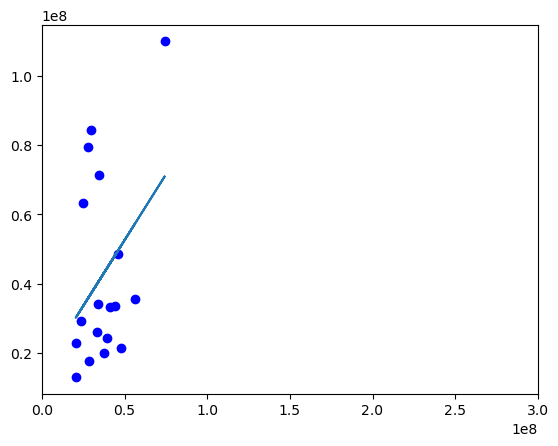

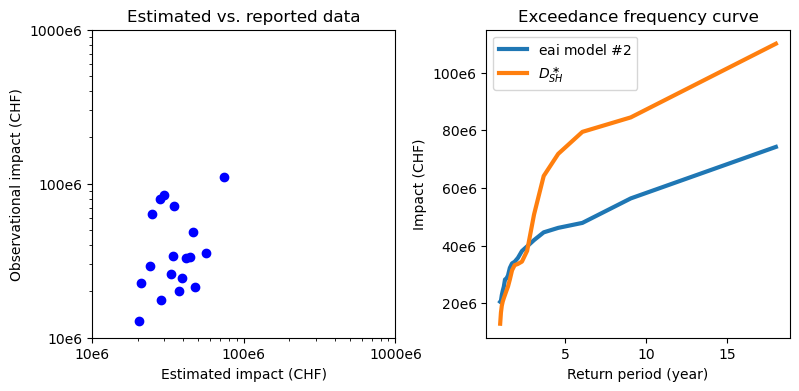

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_sturmarchiv), 1))
for count, i in enumerate(dmg_from_sturmarchiv):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]



fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e7, 1e8, 1e9])
ax[0].set_xticklabels(["10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e7, 1e8, 1e9])
ax[0].set_yticklabels(["10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Observational impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported data")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])
imp_agr_RMSF_year_freq_curve.unit = "CHF"
imp_agr_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3)
imp_sturm_freq_curve.plot(axis = ax[1],linewidth = 3)
ax[1].legend([r"eai model $\# 2$", r"$D_{SH}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[20e6, 40e6, 60e6, 80e6, 100e6])
ax[1].set_yticklabels(labels=["20e6", "40e6", "60e6", "80e6", "100e6"])




#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


# Class Infr

## Class 1

In [25]:
#%% Optimization
if True:
    optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
    sector = "infr" # ["infr", "agr"]
    optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
    score_type = "RMSF" #["pearson", "spearman", "RMSF"]
    type_imp_fun = "class" #["sig", "lin", "class", "const"]
    norm = False
    class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
    bound = [(0.1,1),(1.0,150),(0.0,20)]
    if optimize_type != "":
        num_fct = 1 #[1:3]
        init_parameter=[]
        if sector == "agr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[1:1+num_fct]
                haz = haz_real
                exp = exp_meshs.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                parameter_optimize = imp_fun_parameter[4:4+num_fct]
                haz = haz_dur
                bounds = num_fct*bound
                exp = exp_dur.copy()
        elif sector=="infr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[0:1+num_fct]
                haz = haz_real
                exp = exp_infr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                print("NO dur for infr")

        for i in range(num_fct):
            init_parameter += [*parameter_optimize[i].values()][1:4]

        if num_fct == 1:
            exp["if_HL"] = parameter_optimize[0]["imp_id"]
        if type_imp_fun == "lin":
            bounds = [(0.01,0.03)]
            imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
            parameter_optimize = [imp_fun_lin]
            exp.if_HL = 9
        if type_imp_fun == "class":
            bound = [(0,0.001)]
            if class_mult:
                bounds = [slice(0,0.000_051,0.000_01),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1)]
            else:
                bounds = [slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),       
                          slice(0,0.02,0.000_1),]
            init_parameter = [0,0,0,0]
            parameter_optimize=init_parameter
        if type_imp_fun == "const":
            parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
            bounds = [slice(0.000_000,0.200_0,0.001_0)]
        args = (parameter_optimize, 
                exp, 
                haz, 
                haz_type, 
                num_fct, 
                score_type, 
                type_imp_fun, 
                sector, 
                norm, 
                class_mult,
                optimize_type)
        # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
        optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
        # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
        # test = fct.make_Y(init_parameter, args)
        print(optimize_results)
        print(score_type)
        print(optimize_type)


    Optimization_results.append(create_dict("sector", 
                                            "optimize_type", 
                                            "score_type", 
                                            "type_imp_fun", 
                                            "norm", 
                                            "class_mult", 
                                            "num_fct", 
                                            "bounds", 
                                            "optimize_results"))


2021-03-28 16:25:04,728 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:04,729 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:04,733 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1413578600040637
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0. 0. 0. 0. 0. 0. 0.]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.3038633054443336, 0.2202452537056309)
pearson for agr  (score, p_value) = (-0.18825862454006537, 0.4543989805959836)
RMSF:  484594692.1296334
RMSE 1.5009959327256334e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:04,877 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the or

2021-03-28 16:25:06,173 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:06,175 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1497058550012298
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0009]
The sum of the new Impact is: 9.42e+07
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062529705429, 0.0675173413506357)
RMSF:  87536.65158057195
RMSE 1.3581268591397082e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:06,330 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:06,331 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-0

time to calc impact:  0.16116462500940543
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0018]
The sum of the new Impact is: 1.88e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625375097433, 0.06751734080773236)
RMSF:  79357.80778710474
RMSE 1.2340087476746102e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:07,800 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:07,801 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:07,806 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.16475667199119925
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     

2021-03-28 16:25:09,253 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:09,256 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1482970450015273
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0028]
The sum of the new Impact is: 2.93e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062540296999, 0.06751734061383832)
RMSF:  75632.282244339
RMSE 1.1180916058989046e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:09,410 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:09,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03

time to calc impact:  0.1379564890085021
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0037]
The sum of the new Impact is: 3.87e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062541517363, 0.06751734052894427)
RMSF:  73804.44663610499
RMSE 1.0335588621677326e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:10,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:10,851 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:10,854 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.16815326501091477
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.

2021-03-28 16:25:12,330 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:12,333 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.15147448801144492
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0047]
The sum of the new Impact is: 4.92e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062542325171, 0.06751734047274942)
RMSF:  72534.97229118692
RMSE 9616254623186108.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:12,486 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:12,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.14609410500270315
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0056]
The sum of the new Impact is: 5.86e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062542805528, 0.06751734043933366)
RMSF:  71773.11051902208
RMSE 9166780863213640.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:13,928 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:13,930 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:13,933 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.2696471310046036
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.    

2021-03-28 16:25:15,559 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:15,563 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14483896900492255
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0066]
The sum of the new Impact is: 6.91e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625431856075, 0.06751734041289363)
RMSF:  71183.65241215599
RMSE 8887284283988263.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:15,714 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:15,715 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03

time to calc impact:  0.14347978300065733
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0075]
The sum of the new Impact is: 7.85e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062543441022, 0.06751734039512576)
RMSF:  70806.97256777504
RMSE 8833664201355051.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:17,143 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:17,145 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:17,149 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14181120300781913
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.   

2021-03-28 16:25:18,559 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:18,563 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.15961414300545584
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0085]
The sum of the new Impact is: 8.89e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625436613786, 0.06751734037979687)
RMSF:  70506.55684395916
RMSE 8994005041395513.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:18,725 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:18,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03

time to calc impact:  0.13785551500041038
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0094]
The sum of the new Impact is: 9.84e+08
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062543819613, 0.06751734036878931)
RMSF:  70313.54564174247
RMSE 9336238636101558.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:20,090 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:20,091 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:20,094 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.13764103199355304
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.   

2021-03-28 16:25:21,529 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:21,533 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14578837400767952
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0104]
The sum of the new Impact is: 1.09e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062543963311, 0.06751734035879302)
RMSF:  70162.88577080601
RMSE 9936416895407858.0
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:21,689 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:21,691 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-

time to calc impact:  0.14984182799526025
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0113]
The sum of the new Impact is: 1.18e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062544070892, 0.0675173403513092)
RMSF:  70071.39764400771
RMSE 1.0674504167453164e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:23,176 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:23,177 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:23,180 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1601844890101347
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0. 

2021-03-28 16:25:24,612 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:24,616 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14629574900027364
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0123]
The sum of the new Impact is: 1.29e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062544171963, 0.06751734034427828)
RMSF:  70007.79375938965
RMSE 1.1714519846025298e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:24,764 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:24,764 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021

time to calc impact:  0.13758904401038308
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0132]
The sum of the new Impact is: 1.38e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625442498323, 0.06751734033886135)
RMSF:  69977.80942784029
RMSE 1.2848460795409848e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:26,209 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:26,211 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:26,214 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.16463288800150622
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     

2021-03-28 16:25:27,698 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:27,701 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1572022969921818
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0142]
The sum of the new Impact is: 1.49e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625443247774, 0.06751734033364784)
RMSF:  69968.74196882255
RMSE 1.4328313893247834e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:27,864 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:27,865 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021

time to calc impact:  0.16830252201179974
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0151]
The sum of the new Impact is: 1.58e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625443837424, 0.06751734032954594)
RMSF:  69978.38973603421
RMSE 1.5858108519971656e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:29,350 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:29,351 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:29,354 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.13689776600222103
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     

2021-03-28 16:25:30,765 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:30,769 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1569166929984931
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0161]
The sum of the new Impact is: 1.68e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062544441526, 0.06751734032552627)
RMSF:  70005.29956970425
RMSE 1.777779903707547e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:30,928 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:30,929 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-0

time to calc impact:  0.1530862710060319
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.017]
The sum of the new Impact is: 1.78e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.4402062544487718, 0.06751734032231285)
RMSF:  70041.6228342656
RMSE 1.970344734113853e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:32,379 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:32,380 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:32,384 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1703322940011276
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.   

2021-03-28 16:25:33,842 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:33,845 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14541582099627703
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.018]
The sum of the new Impact is: 1.88e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625445336253, 0.06751734031911946)
RMSF:  70093.16132178447
RMSE 2.2062975277508188e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:33,999 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:34,000 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28

time to calc impact:  0.1379675079951994
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0189]
The sum of the new Impact is: 1.98e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625445707884, 0.06751734031653418)
RMSF:  70148.01320028167
RMSE 2.4384477258910496e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 16:25:35,503 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:35,504 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:35,510 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.14917954699194524
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.

2021-03-28 16:25:36,960 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:36,964 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
time to calc impact:  0.1481341769977007
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.     0.     0.     0.     0.     0.     0.0199]
The sum of the new Impact is: 2.08e+09
spearman for agr  (score, p_value) = (0.4036415802188717, 0.09668943060246099)
pearson for agr  (score, p_value) = (0.44020625446081385, 0.06751734031393593)
RMSF:  70216.86964903607
RMSE 2.7183842614546e+16
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
[0.     0.     0.     0.     0.     0.     0.0141]
RMSF
meshs


Class 3 results:
 {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,0.002,0.000_01),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),]  ,
  'optimize_results': array([0.00014, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ])}]
  
 Class 4 results:
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,1,1),
             slice(0,0.002,0.000_01),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),]
  'optimize_results': array([0.      0.00011 0.      0.      0.      0.      0.     ])}]
  
 Class 5 results:
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,1,1),
             slice(0,1,1),
             slice(0,0.002,0.000_01),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),],
  'optimize_results': array([0.      0.      0.00011 0.      0.      0.      0.     ])}]
  
 Class 6
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,0.002,0.000_01),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),],
  'optimize_results': array([0.      0.      0.      0.00026 0.      0.      0.     ])}]
  
 Class 7
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,0.002,0.000_01),
             slice(0,1,1),
             slice(0,1,1),],
  'optimize_results': array([0.      0.      0.      0.      0.00073 0.      0.     ])}]
  
 Class 8
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,0.02,0.000_1),
             slice(0,1,1),],
  'optimize_results': array([0.     0.     0.     0.     0.     0.0024 0.    ])}]
  
 Class 9
  {'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,1,1),
             slice(0,0.02,0.000_1),],
  'optimize_results': array([0.     0.     0.     0.     0.     0.     0.014])}]

In [26]:
Optimization_results

[{'sector': 'infr',
  'optimize_type': 'meshs',
  'score_type': 'RMSF',
  'type_imp_fun': 'class',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 1, 1),
   slice(0, 0.02, 0.0001)],
  'optimize_results': array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0141])}]

2021-03-28 16:25:37,155 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:37,158 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:37,166 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 52677975.71235706
Correlation of the RMSF data for spearman is 0.35397316821465424 with upper limit 0.7122079885637007 and lower limit -0.15053999098721685 with p value of 0.14955138885906258
Correlation of the RMSF data for pearson is 0.2969012638611217 with upper limit 0.6707902118445849 and lower limit -0.19732021641804065 with a p value of 0.23152971091794183
RMSF is 2.6784238000184506
Coefficients: 
 [[1.32818078]]
Mean squared error: 1087956998558314.62
Coefficient of determination: -1.80


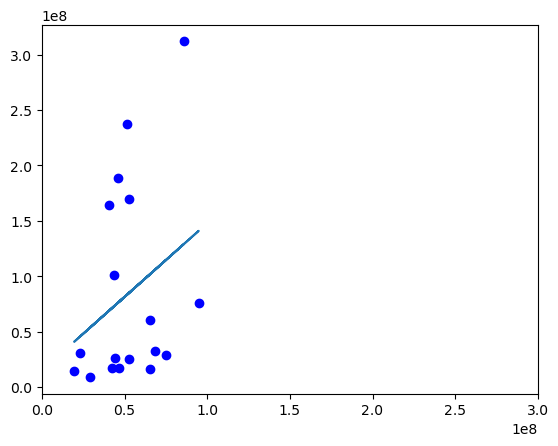

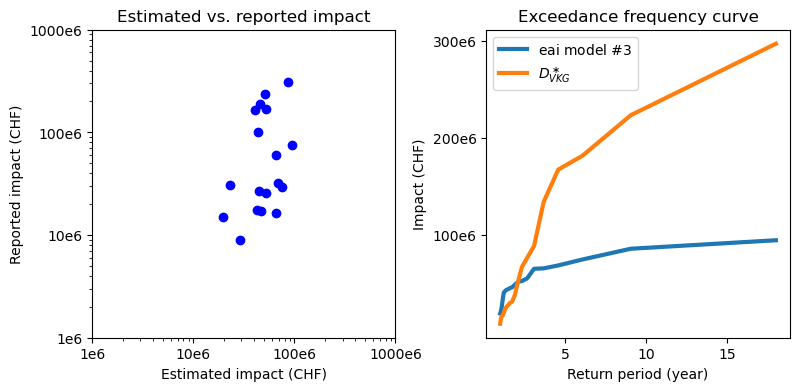

In [27]:
#Class 3
y = np.zeros(150)
y[:] = 0
y[20:30] = 0.000_14
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))



#plot
#plt.figure()
#plt.plot(years, list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
#plt.plot(dmg_from_vkg, linewidth = 3)
#plt.legend([r"aai_agg $\# 1$", r"$D_{VKG}^\ast$"])
#plt.xticks(rotation = 45)
#plt.show()
Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

#plt.rcParams['figure.figsize'] = [9/4*3, 4/4*3]
plt.rcParams['figure.figsize'] = [9, 4]

X_c3 = cp.copy(X)
fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"
imp_RMSF_year_freq_curve_c3 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 3$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)



2021-03-28 16:25:38,565 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:38,566 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:38,571 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 55065983.244097225
Correlation of the RMSF data for spearman is 0.5397316821465429 with upper limit 0.81623787908811 and lower limit 0.062033851045538234 with p value of 0.020782714646741193
Correlation of the RMSF data for pearson is 0.3059851001095558 with upper limit 0.6762493756494311 and lower limit -0.18769872923916778 with a p value of 0.2168782436755419
RMSF is 2.533319912480344
Coefficients: 
 [[1.30576903]]
Mean squared error: 937259142258624.75
Coefficient of determination: -1.19


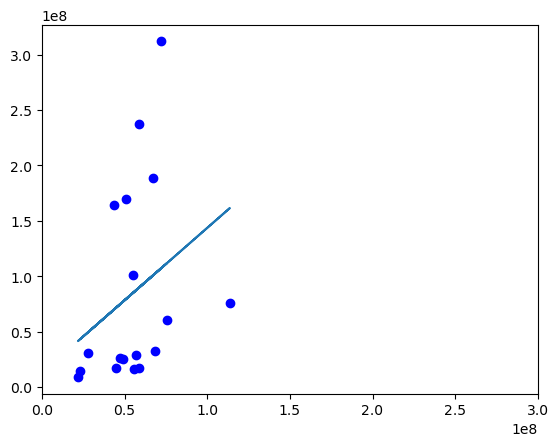

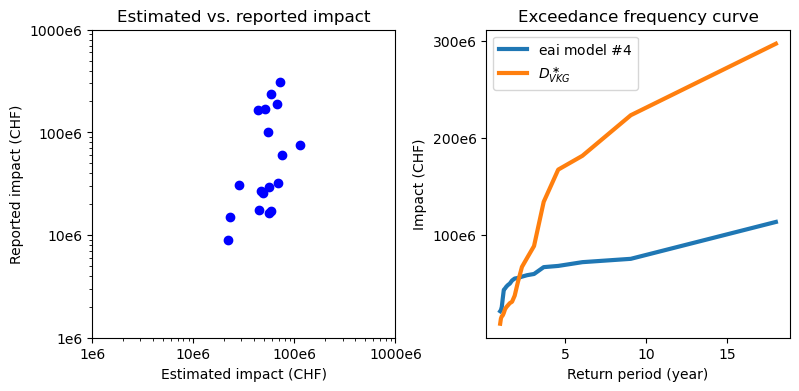

In [28]:
# Class 4
y = np.zeros(150)
y[:] = 0
y[25:40] = 0.000_11
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))




Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]


X_c4 = cp.copy(X)
fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"

imp_RMSF_year_freq_curve_c4 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 4$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


2021-03-28 16:25:40,016 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:40,018 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:40,023 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 51221380.367248036
Correlation of the RMSF data for spearman is 0.4324045407636739 with upper limit 0.7582297892183736 and lower limit -0.06623952587858496 with p value of 0.0731081920707255
Correlation of the RMSF data for pearson is 0.2221707424359567 with upper limit 0.6242867532211781 and lower limit -0.27301809820919243 with a p value of 0.375580225693122
RMSF is 2.580057412938852
Coefficients: 
 [[0.9530173]]
Mean squared error: 1143355276691504.00
Coefficient of determination: -1.70


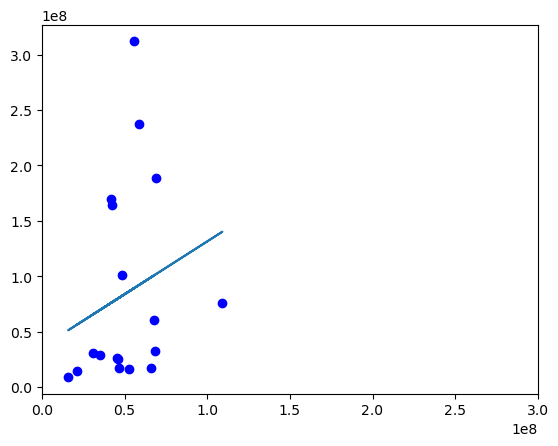

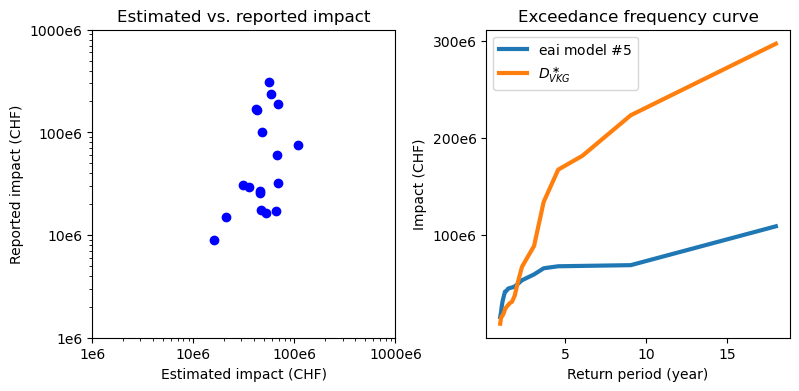

In [29]:
# Class 5
y = np.zeros(150)
y[:] = 0
y[30:50] = 0.000_11
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))




Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]

X_c5 = cp.copy(X)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"

imp_RMSF_year_freq_curve_c5 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 5$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

2021-03-28 16:25:41,616 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:41,618 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:41,621 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 54642540.58139258
Correlation of the RMSF data for spearman is 0.3333333333333333 with upper limit 0.6995921936065603 and lower limit -0.17163826982118116 with p value of 0.17646319681352732
Correlation of the RMSF data for pearson is 0.23180367981840472 with upper limit 0.6304455485569053 and lower limit -0.2635930095174395 with a p value of 0.3546797720086893
RMSF is 2.6698585801276686
Coefficients: 
 [[0.92971602]]
Mean squared error: 925247056919551.25
Coefficient of determination: -0.91


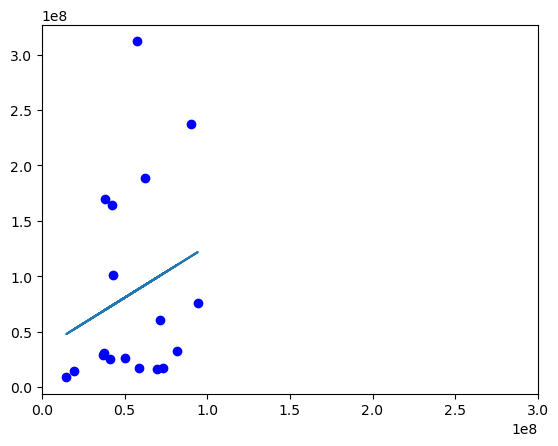

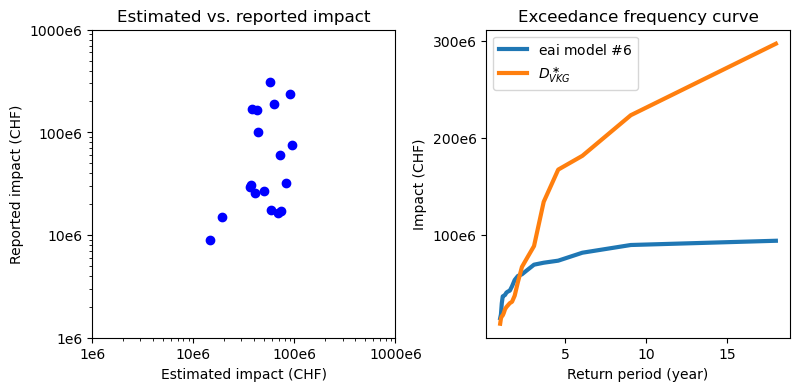

In [30]:
# Class 6
y = np.zeros(150)
y[:] = 0
y[40:60] = 0.000_26
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))




Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]


X_c6 = cp.copy(X)
fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"

imp_RMSF_year_freq_curve_c6 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 6$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


2021-03-28 16:25:42,842 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:42,843 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:42,847 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 60163289.476138934
Correlation of the RMSF data for spearman is 0.36429308565531476 with upper limit 0.7184372686808547 and lower limit -0.13983139500392067 with p value of 0.1372167161243323
Correlation of the RMSF data for pearson is 0.18399664724550627 with upper limit 0.5993785850667489 and lower limit -0.3094565242288634 with a p value of 0.46486161626533423
RMSF is 2.9744017386669754
Coefficients: 
 [[0.39642834]]
Mean squared error: 1228577907333273.00
Coefficient of determination: 0.27


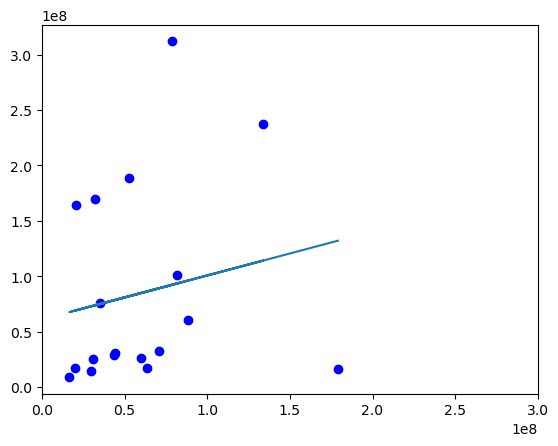

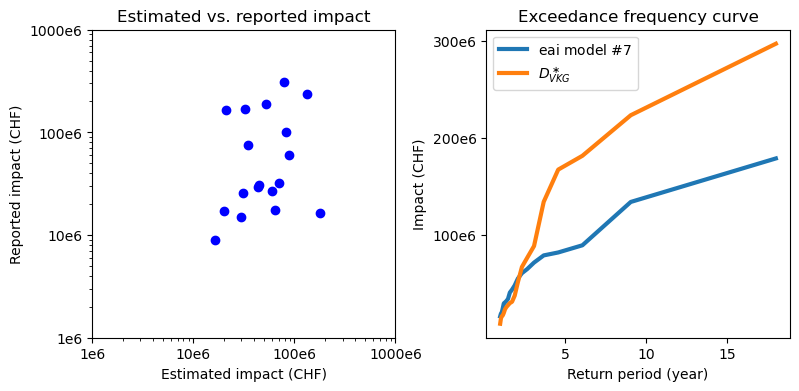

In [31]:
# Class 7
y = np.zeros(150)
y[:] = 0
y[50:75] = 0.000_73
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))




Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]

X_c7 = cp.copy(X)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"

imp_RMSF_year_freq_curve_c7 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 7$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


2021-03-28 16:25:44,001 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:44,003 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:44,007 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 86084694.2273624
Correlation of the RMSF data for spearman is 0.32094943240454077 with upper limit 0.6919222812115088 and lower limit -0.18410057824919207 with p value of 0.19408223512614617
Correlation of the RMSF data for pearson is 0.15753781452053564 with upper limit 0.5816292374482472 and lower limit -0.33388974687197215 with a p value of 0.5324234695333145
RMSF is 4.044286548691534
Coefficients: 
 [[0.15065275]]
Mean squared error: 6139347333453220.00
Coefficient of determination: 0.28


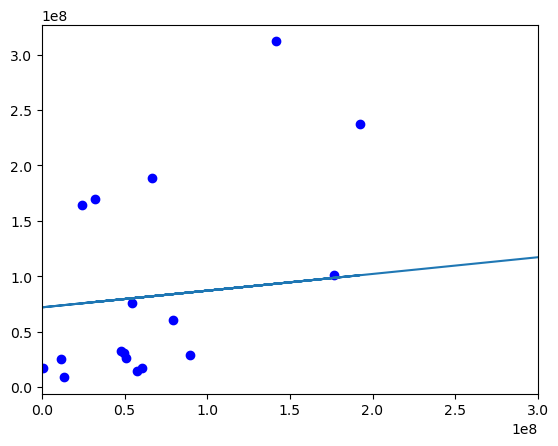

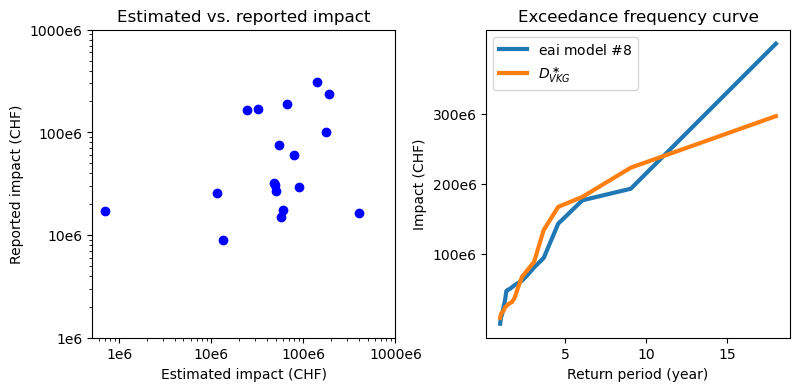

In [32]:
# Class 8
y = np.zeros(150)
y[:] = 0
y[60:90] = 0.002_4
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))




Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]

X_c8 = cp.copy(X)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"

imp_RMSF_year_freq_curve_c8 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 8$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


2021-03-28 16:25:45,136 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 16:25:45,138 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 16:25:45,145 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
RMSF aai_agg 81390406.71709482
Correlation of the RMSF data for spearman is 0.4036415802188717 with upper limit 0.7417061930612862 and lower limit -0.09796278373573937 with p value of 0.09668943060246099
Correlation of the RMSF data for pearson is 0.4402062545314056 with upper limit 0.7524362809906079 and lower limit -0.033561310304775153 with a p value of 0.06751734026482913
RMSF is inf
Coefficients: 
 [[0.3063974]]
Mean squared error: 7740339709905719.00
Coefficient of determination: 0.52


/home/jan/Documents/ETH/Masterarbeit/climada_hail_script/hail_functions.py:548: RuntimeWarning: divide by zero encountered in log
  res += np.log(Y[i]/X[i])**2


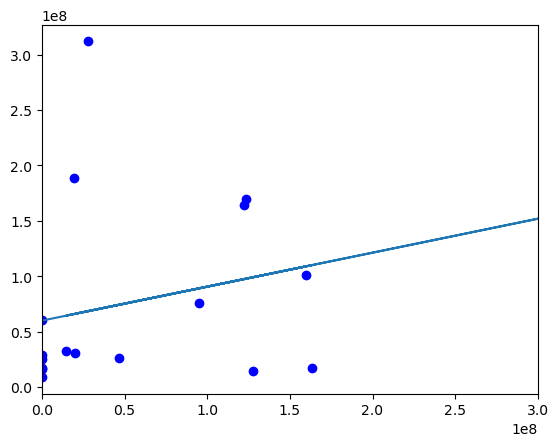

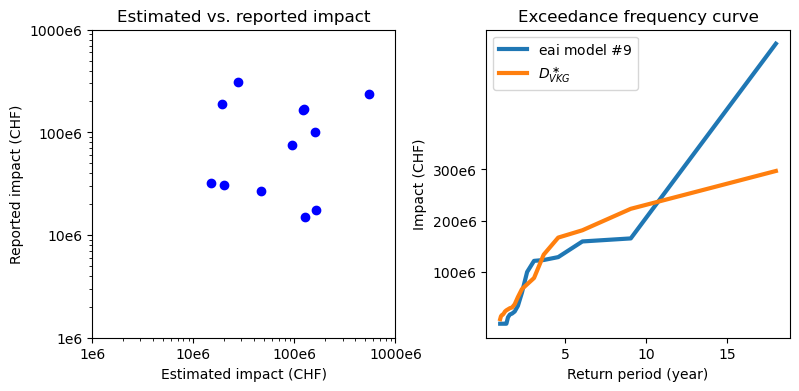

In [33]:
# Class 9
# Does not work since in some years no event where a hail event (only hail sizes of 80mm+ are considered)
# happens over an exposure (exposure > 0).

y = np.zeros(150)
y[:] = 0
y[80:150] = 0.014
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF = Impact()
imp_RMSF.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
print("RMSF aai_agg {}".format(imp_RMSF.aai_agg))




Y_RMSF = list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_vkg), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_vkg), 1))
for count, i in enumerate(dmg_from_vkg):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]



fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"



imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 9$", r"$D_{VKG}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[1].set_yticklabels(labels=["100e6","200e6","300e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


Text(0.5, 1.0, 'Estimated vs. reported impact')

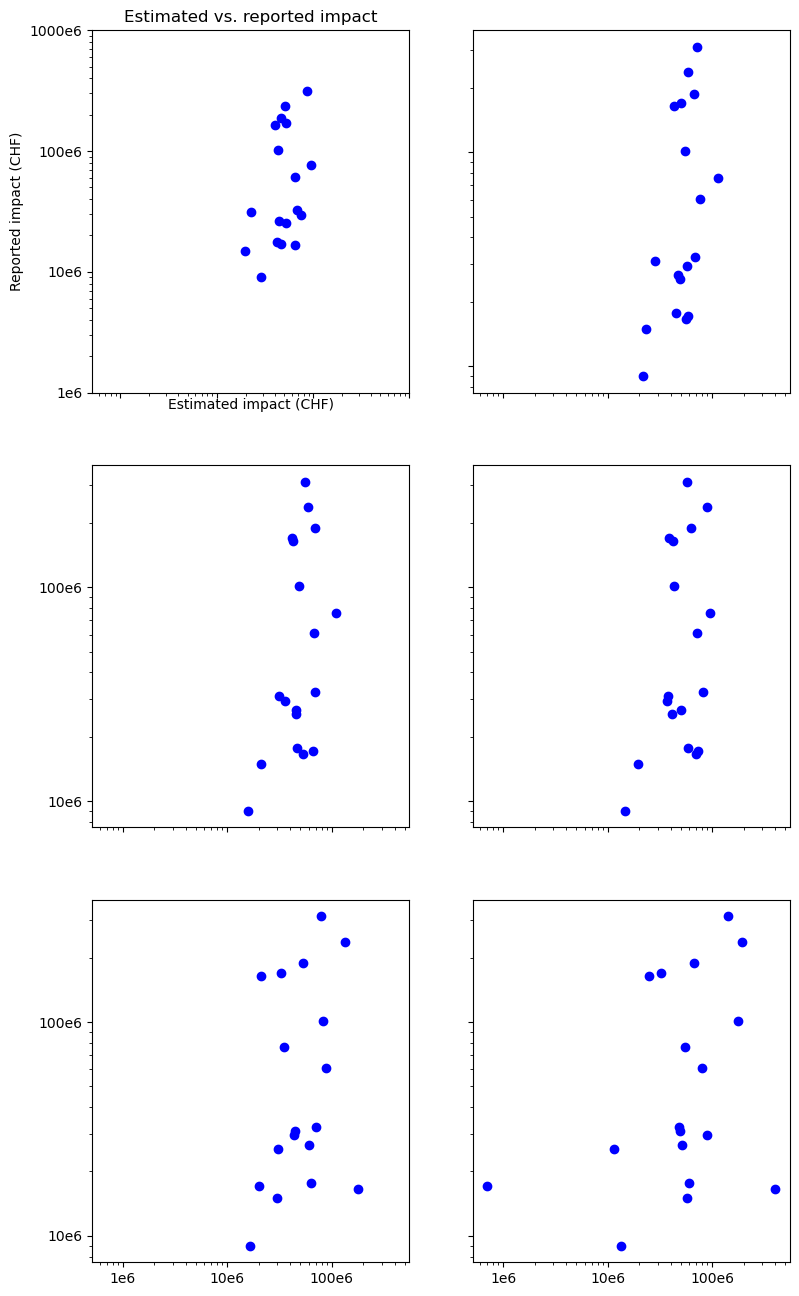

In [34]:
plt.rcParams['figure.figsize'] = [9, 16]

fig, ax = plt.subplots(3,2, sharex=True, sharey=True)

ax[0,0].plot(X_c3, y, "bo")
ax[0,1].plot(X_c4, y, "bo")
ax[1,0].plot(X_c5, y, "bo")
ax[1,1].plot(X_c6, y, "bo")
ax[2,0].plot(X_c7, y, "bo")
ax[2,1].plot(X_c8, y, "bo")


ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].set_xticks([1e6, 1e7, 1e8, 1e9])
ax[0,0].set_xticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0,0].set_yticks([1e6, 1e7, 1e8, 1e9])
ax[0,0].set_yticklabels(["1e6", "10e6", "100e6", "1000e6"])
ax[0,0].set_ylabel(r"Reported impact (CHF)")
ax[0,0].set_xlabel("Estimated impact (CHF)")
ax[0,0].set_title("Estimated vs. reported impact")



NameError: name 'imp_RMSF_year_freq_curve_c1' is not defined

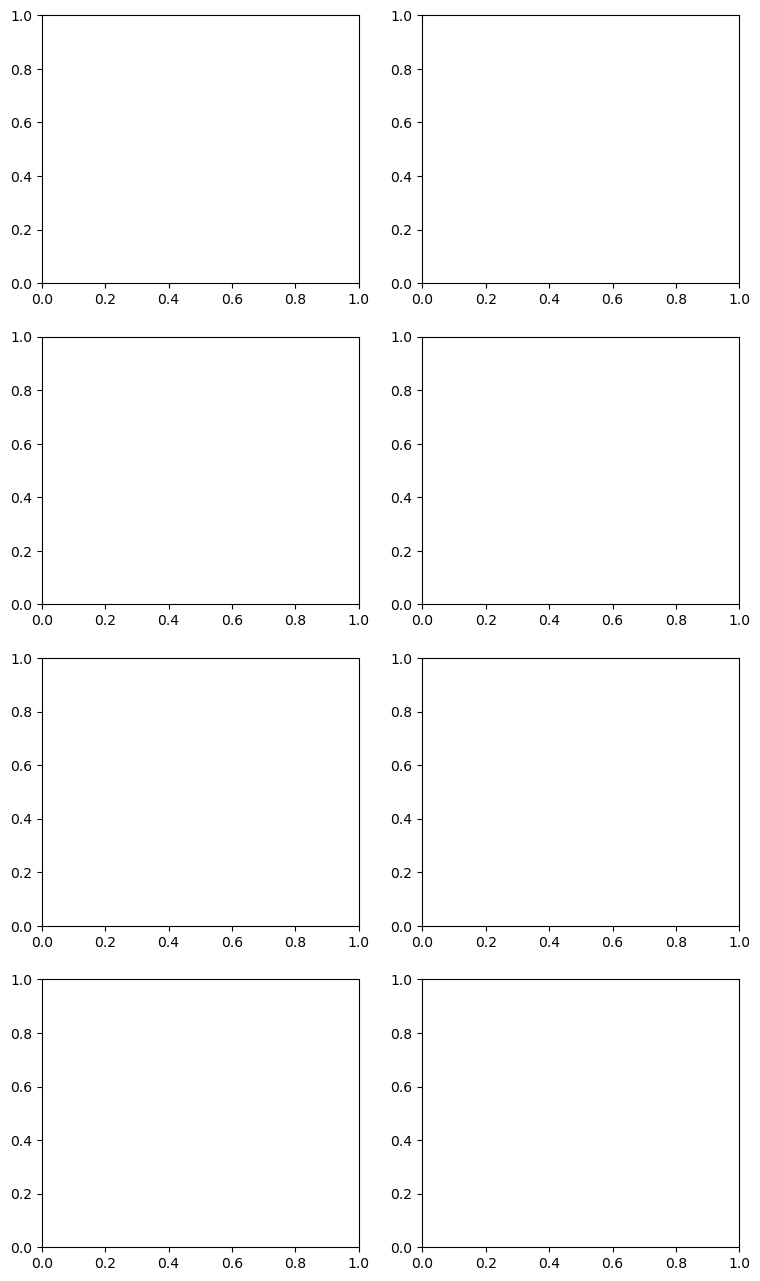

In [35]:
fig, ax = plt.subplots(4,2)

imp_RMSF_year_freq_curve_c1.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_vkg_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[0].legend([r"eai model $\# 9$", r"$D_{VKG}^\ast$"])
ax[0].set_ylabel("Impact (CHF)")
ax[0].set_yticks(ticks=[100e6, 200e6, 300e6])
ax[0].set_yticklabels(labels=["100e6","200e6","300e6"])

In [36]:
imp_RMSF.calc_impact_year_set([2002, 2019])

{2002: 122019087.96881081,
 2003: 14846415.276576884,
 2004: 159921939.07775933,
 2005: 123503170.0808053,
 2006: 46612030.40221138,
 2007: 20157925.17659677,
 2008: 163693053.02052033,
 2009: 27734594.392558042,
 2010: 127864010.74076653,
 2011: 544557334.6190829,
 2012: 94941673.7143626,
 2013: 19176086.437656067,
 2014: 0.0,
 2015: 0.0,
 2016: 0.0,
 2017: 0.0,
 2018: 0.0,
 2019: 0.0}

In [37]:
return_period

array([ 1.        ,  1.04709141,  1.0994152 ,  1.15789474,  1.22368421,
        1.29824561,  1.38345865,  1.48178138,  1.59649123,  1.73205742,
        1.89473684,  2.09356725,  2.34210526,  2.66165414,  3.0877193 ,
        3.68421053,  4.57894737,  6.07017544,  9.05263158, 18.        ])

2021-03-28 20:42:49,421 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:42:49,425 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:42:49,431 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 20:42:49,756 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:42:49,757 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:42:49,760 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-03-28 20:42:50,000 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

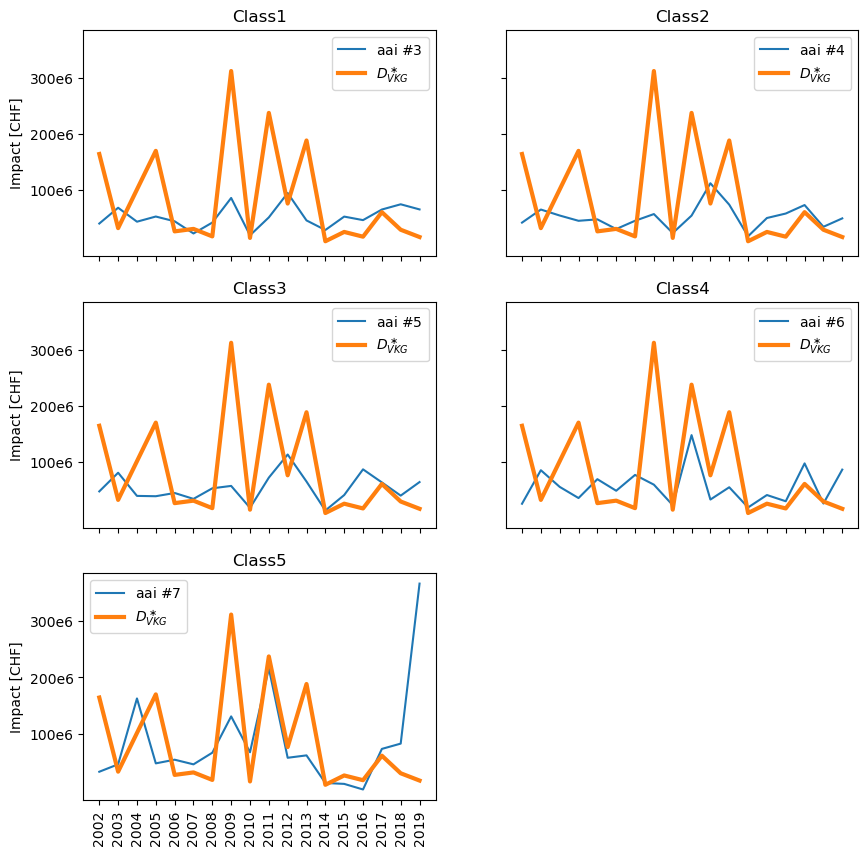

In [38]:
import matplotlib.ticker as ticker
# All Classes
#c1
y = np.zeros(150)
y[:] = 0
y[20:30] = 0.000_14
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c1 = Impact()
imp_RMSF_c1.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c2
y = np.zeros(150)
y[:] = 0
y[30:40] = 0.000_17
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c2 = Impact()
imp_RMSF_c2.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c3
y = np.zeros(150)
y[:] = 0
y[40:50] = 0.000_34
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c3 = Impact()
imp_RMSF_c3.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c4
y = np.zeros(150)
y[:] = 0
y[50:60] = 0.001_1
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c4 = Impact()
imp_RMSF_c4.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#c5
y = np.zeros(150)
y[:] = 0
y[60:150] = 0.002_2
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         1,
                                         0,
                                         0,
                                         0,
                                         y))

imp_RMSF_c5 = Impact()
imp_RMSF_c5.calc(exp_infr, ifset_hail, haz_real, save_mat=True)

#plot
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

axs[0,0].plot(years, list(imp_RMSF_c1.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0,1].plot(years, list(imp_RMSF_c2.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[1,0].plot(years, list(imp_RMSF_c3.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[1,1].plot(years, list(imp_RMSF_c4.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[2,0].plot(years, list(imp_RMSF_c5.calc_impact_year_set(year_range=[2002,2019]).values()))

axs[0,0].plot(dmg_from_vkg, linewidth = 3)
axs[0,1].plot(dmg_from_vkg, linewidth = 3)
axs[1,0].plot(dmg_from_vkg, linewidth = 3)
axs[1,1].plot(dmg_from_vkg, linewidth = 3)
axs[2,0].plot(dmg_from_vkg, linewidth = 3)

axs[2,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis='x', rotation=90)

axs[0,0].legend([r"aai $\# 3$", r"$D_{VKG}^\ast$"])
axs[0,1].legend([r"aai $\# 4$", r"$D_{VKG}^\ast$"])
axs[1,0].legend([r"aai $\# 5$", r"$D_{VKG}^\ast$"])
axs[1,1].legend([r"aai $\# 6$", r"$D_{VKG}^\ast$"])
axs[2,0].legend([r"aai $\# 7$", r"$D_{VKG}^\ast$"])

axs[0,0].title.set_text('Class1')
axs[0,1].title.set_text('Class2')
axs[1,0].title.set_text('Class3')
axs[1,1].title.set_text('Class4')
axs[2,0].title.set_text('Class5')

axs[0,0].set_ylabel("Impact [CHF]")
axs[1,0].set_ylabel("Impact [CHF]")
axs[2,0].set_ylabel("Impact [CHF]")


#y_labels = axs[0,0].get_yticks()
#axs[0,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.0e'))

axs[0,0].set_yticks(ticks=[100e6, 200e6, 300e6])
axs[0,0].set_yticklabels(labels=["100e6","200e6","300e6"])
#axs[1,0].ticklabel_format(style='sci',scilimits=(0,0),axis='y')

axs[2,1].set_visible(False)
plt.show()

matplotlib.rcParams.update(matplotlib.rcParamsDefault)




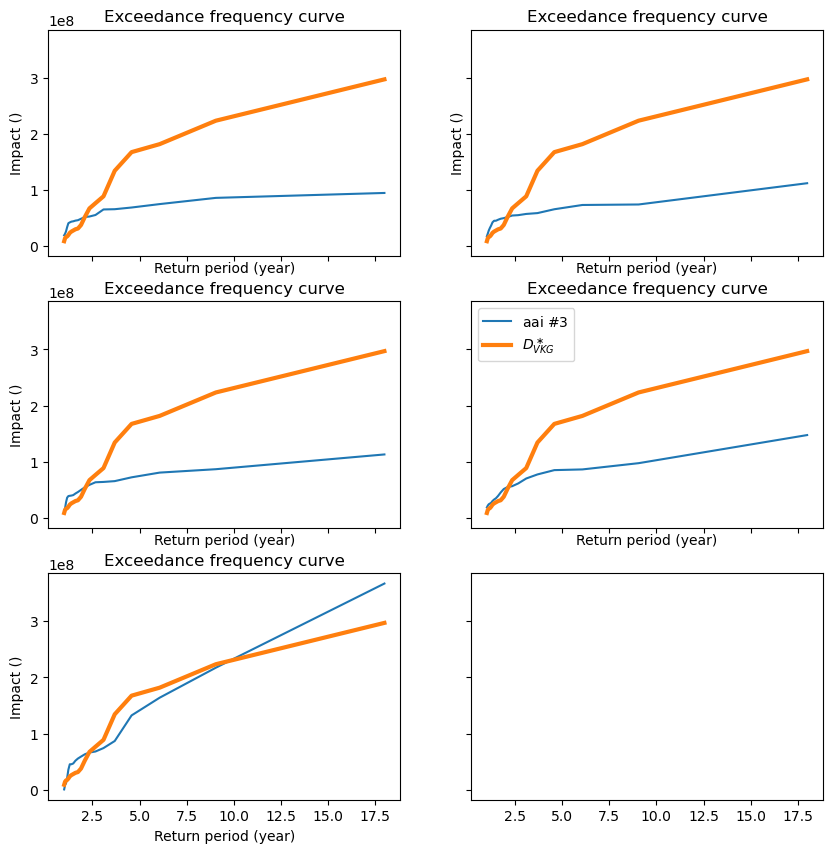

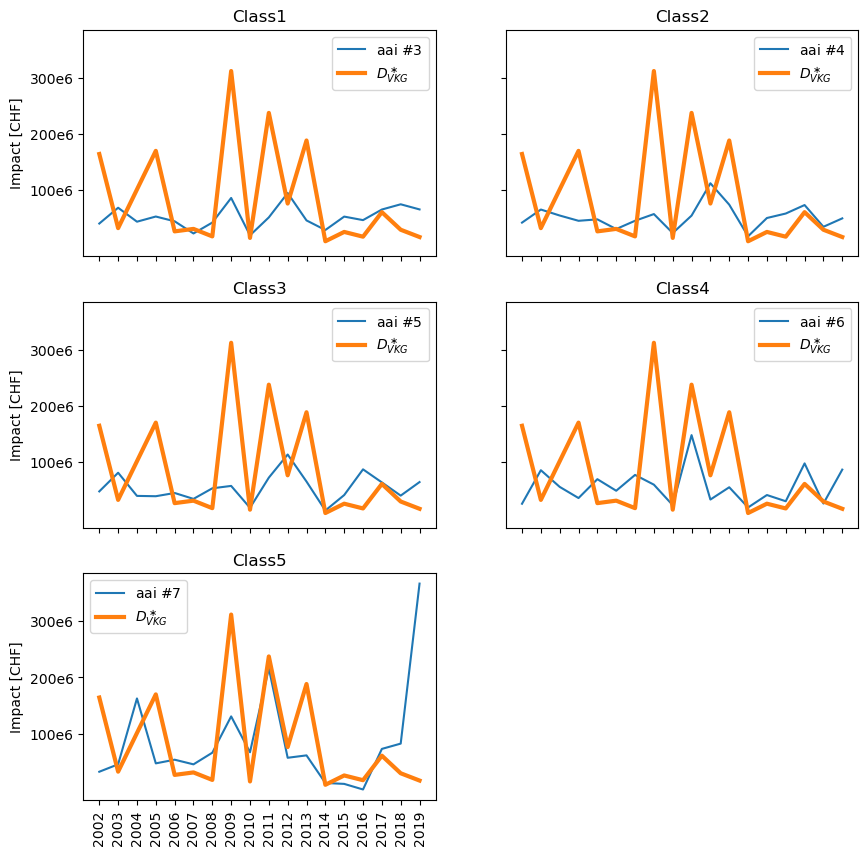

In [39]:
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

imp_RMSF_c1_year = Impact()
imp_RMSF_c2_year = Impact()
imp_RMSF_c3_year = Impact()
imp_RMSF_c4_year = Impact()
imp_RMSF_c5_year = Impact()

imp_RMSF_c1_year.at_event = np.asarray(list(imp_RMSF_c1.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_c2_year.at_event = np.asarray(list(imp_RMSF_c2.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_c3_year.at_event = np.asarray(list(imp_RMSF_c3.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_c4_year.at_event = np.asarray(list(imp_RMSF_c4.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_c5_year.at_event = np.asarray(list(imp_RMSF_c5.calc_impact_year_set(year_range=[2002,2019]).values()))

imp_RMSF_c1_year.frequency = np.ones(len(imp_RMSF_c1_year.at_event))/len(imp_RMSF_c1_year.at_event)
imp_RMSF_c2_year.frequency = np.ones(len(imp_RMSF_c2_year.at_event))/len(imp_RMSF_c2_year.at_event)
imp_RMSF_c3_year.frequency = np.ones(len(imp_RMSF_c3_year.at_event))/len(imp_RMSF_c3_year.at_event)
imp_RMSF_c4_year.frequency = np.ones(len(imp_RMSF_c4_year.at_event))/len(imp_RMSF_c4_year.at_event)
imp_RMSF_c5_year.frequency = np.ones(len(imp_RMSF_c5_year.at_event))/len(imp_RMSF_c5_year.at_event)

imp_RMSF_c1_year_freq_curve = imp_RMSF_c1_year.calc_freq_curve(return_per = return_period)
imp_RMSF_c2_year_freq_curve = imp_RMSF_c2_year.calc_freq_curve(return_per = return_period)
imp_RMSF_c3_year_freq_curve = imp_RMSF_c3_year.calc_freq_curve(return_per = return_period)
imp_RMSF_c4_year_freq_curve = imp_RMSF_c4_year.calc_freq_curve(return_per = return_period)
imp_RMSF_c5_year_freq_curve = imp_RMSF_c5_year.calc_freq_curve(return_per = return_period)


imp_RMSF_c1_year_freq_curve.unit = "CHF"
imp_RMSF_c2_year_freq_curve.unit = "CHF"
imp_RMSF_c3_year_freq_curve.unit = "CHF"
imp_RMSF_c4_year_freq_curve.unit = "CHF"
imp_RMSF_c5_year_freq_curve.unit = "CHF"

imp_RMSF_c1_year_freq_curve.plot(axis=axs[0,0])
imp_RMSF_c2_year_freq_curve.plot(axis=axs[0,1])
imp_RMSF_c3_year_freq_curve.plot(axis=axs[1,0])
imp_RMSF_c4_year_freq_curve.plot(axis=axs[1,1])
imp_RMSF_c5_year_freq_curve.plot(axis=axs[2,0])

imp_vkg_freq_curve.plot(axis=axs[0,0], linewidth = 3)
imp_vkg_freq_curve.plot(axis=axs[0,1], linewidth = 3)
imp_vkg_freq_curve.plot(axis=axs[1,0], linewidth = 3)
imp_vkg_freq_curve.plot(axis=axs[1,1], linewidth = 3)
imp_vkg_freq_curve.plot(axis=axs[2,0], linewidth = 3)

axs[1,1].legend([r"aai $\# 3$", r"$D_{VKG}^\ast$"])
axs[1,1].set_ylabel("")




#plot
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

axs[0,0].plot(years, list(imp_RMSF_c1.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0,1].plot(years, list(imp_RMSF_c2.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[1,0].plot(years, list(imp_RMSF_c3.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[1,1].plot(years, list(imp_RMSF_c4.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[2,0].plot(years, list(imp_RMSF_c5.calc_impact_year_set(year_range=[2002,2019]).values()))

axs[0,0].plot(dmg_from_vkg, linewidth = 3)
axs[0,1].plot(dmg_from_vkg, linewidth = 3)
axs[1,0].plot(dmg_from_vkg, linewidth = 3)
axs[1,1].plot(dmg_from_vkg, linewidth = 3)
axs[2,0].plot(dmg_from_vkg, linewidth = 3)

axs[2,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis='x', rotation=90)

axs[0,0].legend([r"aai $\# 3$", r"$D_{VKG}^\ast$"])
axs[0,1].legend([r"aai $\# 4$", r"$D_{VKG}^\ast$"])
axs[1,0].legend([r"aai $\# 5$", r"$D_{VKG}^\ast$"])
axs[1,1].legend([r"aai $\# 6$", r"$D_{VKG}^\ast$"])
axs[2,0].legend([r"aai $\# 7$", r"$D_{VKG}^\ast$"])

axs[0,0].title.set_text('Class1')
axs[0,1].title.set_text('Class2')
axs[1,0].title.set_text('Class3')
axs[1,1].title.set_text('Class4')
axs[2,0].title.set_text('Class5')

axs[0,0].set_ylabel("Impact [CHF]")
axs[1,0].set_ylabel("Impact [CHF]")
axs[2,0].set_ylabel("Impact [CHF]")


#y_labels = axs[0,0].get_yticks()
#axs[0,0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.0e'))

axs[0,0].set_yticks(ticks=[100e6, 200e6, 300e6])
axs[0,0].set_yticklabels(labels=["100e6","200e6","300e6"])
#axs[1,0].ticklabel_format(style='sci',scilimits=(0,0),axis='y')

axs[2,1].set_visible(False)
plt.show()

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Class on Agriculture

In [51]:
#%% Optimization
if True:
    optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
    sector = "agr" # ["infr", "agr"]
    optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
    score_type = "RMSF" #["pearson", "spearman", "RMSF"]
    type_imp_fun = "class" #["sig", "lin", "class", "const"]
    norm = False
    class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
    bound = [(0.1,1),(1.0,150),(0.0,20)]
    if optimize_type != "":
        num_fct = 1 #[1:3]
        init_parameter=[]
        if sector == "agr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[1:1+num_fct]
                haz = haz_real
                exp = exp_agr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                parameter_optimize = imp_fun_parameter[4:4+num_fct]
                haz = haz_dur
                bounds = num_fct*bound
                exp = exp_dur.copy()
        elif sector=="infr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[0:1+num_fct]
                haz = haz_real
                exp = exp_infr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                print("NO dur for infr")

        for i in range(num_fct):
            init_parameter += [*parameter_optimize[i].values()][1:4]

        if num_fct == 1:
            exp["if_HL"] = parameter_optimize[0]["imp_id"]
        if type_imp_fun == "lin":
            bounds = [(0.01,0.03)]
            imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
            parameter_optimize = [imp_fun_lin]
            exp.if_HL = 9
        if type_imp_fun == "class":
            bound = [(0,0.001)]
            if class_mult:
                bounds = [slice(0,0.000_051,0.000_01),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1)]
            else:
                bounds = [slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),       
                          slice(0,1,0.001),]
            init_parameter = [0,0,0,0]
            parameter_optimize=init_parameter
        if type_imp_fun == "const":
            parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
            bounds = [slice(0.000_000,0.200_0,0.001_0)]
        args = (parameter_optimize, 
                exp, 
                haz, 
                haz_type, 
                num_fct, 
                score_type, 
                type_imp_fun, 
                sector, 
                norm, 
                class_mult,
                optimize_type)
        # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
        optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
        # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
        # test = fct.make_Y(init_parameter, args)
        print(optimize_results)
        print(score_type)
        print(optimize_type)


    Optimization_results.append(create_dict("sector", 
                                            "optimize_type", 
                                            "score_type", 
                                            "type_imp_fun", 
                                            "norm", 
                                            "class_mult", 
                                            "num_fct", 
                                            "bounds", 
                                            "optimize_results"))


2021-03-28 20:54:12,234 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:12,240 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:12,247 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:12,250 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.012738435005303472
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0. 0. 0. 0. 0. 0. 0.]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:12,259 - climada

2021-03-28 20:54:12,544 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:12,549 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.023633738994249143
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.008]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:12,562 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:12,567 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 2

2021-03-28 20:54:12,868 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:12,879 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:12,883 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.018746998001006432
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.017]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:12,901 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.021409730004961602
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.025]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:13,183 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:13,185 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:13,198 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:13,201 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:13,464 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:13,476 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:13,479 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01694771299662534
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.034]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:13,493 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.01725829899078235
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.042]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:13,796 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:13,797 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:13,808 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:13,814 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:14,064 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:14,078 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:14,083 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022033890010789037
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.051]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:14,101 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.021460325006046332
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.059]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:14,382 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:14,383 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:14,395 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:14,398 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:14,665 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:14,683 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:14,689 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.03207857099187095
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.068]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:14,702 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.0318674799927976
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.076]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:14,986 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:14,988 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:14,998 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:15,002 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc i

2021-03-28 20:54:15,270 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:15,280 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:15,284 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.020860849996097386
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.085]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:15,306 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.018761598999844864
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.093]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:15,598 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:15,599 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:15,610 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:15,615 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:15,851 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:15,865 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:15,868 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02131053699122276
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.102]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:15,888 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.016793786999187432
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.11]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:16,165 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:16,168 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:16,176 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:16,179 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact

2021-03-28 20:54:16,465 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:16,475 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:16,478 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.015789106997544877
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.119]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:16,488 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.01758716300537344
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.127]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:16,795 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:16,799 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:16,810 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:16,814 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:17,162 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:17,164 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:17,177 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:17,189 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.029470609995769337
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.136]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788

2021-03-28 20:54:17,624 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:17,628 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.018460115999914706
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.144]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:17,648 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:17,650 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 2

2021-03-28 20:54:17,936 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:17,964 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:17,975 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.04196131700882688
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.153]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:18,008 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.01808927000092808
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.161]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:18,302 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:18,305 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:18,318 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:18,323 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:18,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:18,613 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:18,615 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.0159273659955943
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.17]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:18,632 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:18,6

time to calc impact:  0.022490729999844916
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.178]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:18,913 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:18,916 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:18,929 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:18,932 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:19,214 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:19,222 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:19,226 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.016440095991129056
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.187]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:19,242 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.02017730599618517
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.195]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:19,499 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:19,500 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:19,515 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:19,521 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:19,787 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:19,796 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:19,804 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:19,813 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.020204770000418648
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.204]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 2

2021-03-28 20:54:20,078 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:20,081 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01872559101320803
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.212]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:20,092 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:20,096 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20

spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:20,387 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:20,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:20,404 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:20,409 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022085495002102107
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.221]
The sum of the new Impact is: 1.90e+00
spearman for

2021-03-28 20:54:20,711 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:20,727 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:20,735 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.026570757996523753
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.229]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:20,763 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.013658860989380628
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.237]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:21,145 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:21,147 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:21,159 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:21,163 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:21,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:21,426 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:21,429 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02140249799413141
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.246]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:21,444 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.016348083008779213
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.254]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:21,725 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:21,728 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:21,737 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:21,743 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:22,007 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:22,017 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:22,021 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01883382500091102
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.263]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:22,039 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.018755165991024114
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.271]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:22,334 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:22,336 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:22,352 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:22,355 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:22,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:22,656 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:22,663 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.021301114989910275
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.28]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:22,681 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:22

time to calc impact:  0.02653686200210359
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.288]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:22,945 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:22,946 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:22,958 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:22,965 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:23,228 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:23,238 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:23,243 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.017787259988836013
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.297]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:23,254 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.03247634498984553
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.305]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:23,562 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:23,564 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:23,586 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:23,597 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:23,943 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:23,952 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:23,956 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022151236000354402
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.314]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:23,969 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.01584505800565239
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.322]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:24,263 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:24,265 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:24,276 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:24,280 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:24,538 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:24,548 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:24,551 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.016460883998661302
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.331]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:24,565 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.01760731899412349
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.339]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:24,851 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:24,852 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:24,863 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:24,866 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:25,233 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:25,245 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:25,264 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.038840962006361224
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.348]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:25,284 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.026630106003722176
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.356]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:25,598 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:25,599 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:25,614 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:25,618 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:25,896 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:25,912 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:25,915 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02151052700355649
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.365]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:25,930 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.02083021200087387
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.373]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:26,217 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:26,218 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:26,232 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:26,235 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:26,504 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:26,516 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:26,523 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.023008125004707836
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.382]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:26,539 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.022139159991638735
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.39]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:26,812 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:26,814 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:26,825 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:26,832 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact

2021-03-28 20:54:27,097 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:27,107 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:27,114 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.021460892996401526
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.399]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:27,126 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.020777736004674807
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.407]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:27,408 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:27,410 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:27,420 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:27,425 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:27,697 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:27,708 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:27,711 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01703024400922004
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.416]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:27,726 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.016120236992719583
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.424]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:28,015 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:28,016 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:28,025 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:28,028 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:28,291 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:28,300 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:28,303 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.016733803000533953
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.433]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:28,321 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.021048654001788236
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.441]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:28,601 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:28,602 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:28,611 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:28,615 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:28,869 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:28,881 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:28,884 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.017779001005692407
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.45]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:28,894 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:28

time to calc impact:  0.019031301999348216
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.458]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:29,164 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:29,166 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:29,183 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:29,189 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:29,480 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:29,484 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:29,498 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:29,505 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.025435677991481498
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.467]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for 

2021-03-28 20:54:29,841 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:29,849 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:29,855 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.020774497999809682
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.475]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:29,876 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.0302446499990765
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.483]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:30,167 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:30,171 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:30,185 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:30,197 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc i

2021-03-28 20:54:30,513 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:30,526 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:30,531 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02152128801390063
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.492]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:30,554 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.020387926997500472
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.  0.  0.  0.  0.  0.  0.5]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:30,843 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:30,844 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:30,855 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:30,865 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:31,185 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:31,189 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:31,203 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:31,208 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.023056263002217747
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.509]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXX

2021-03-28 20:54:31,562 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:31,566 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022228750996873714
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.517]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:31,583 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:31,584 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 2

pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:31,950 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:31,955 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:31,967 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:31,971 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.018255058996146545
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.526]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for 

2021-03-28 20:54:32,240 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:32,249 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:32,253 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.021129651999217458
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.534]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:32,271 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.021724191989051178
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.542]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:32,562 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:32,565 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:32,576 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:32,581 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:32,871 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:32,881 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:32,884 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.017184359996463172
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.551]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:32,898 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.023308682008064352
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.559]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:33,217 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:33,219 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:33,232 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:33,241 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:33,664 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:33,675 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:33,681 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.020016280002892017
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.568]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:33,695 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.018347238001297228
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.576]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:33,978 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:33,980 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:33,996 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:34,003 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:34,278 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:34,290 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:34,298 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02361692399426829
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.585]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:34,319 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.01733625000633765
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.593]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:34,587 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:34,595 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:34,609 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:34,615 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:34,944 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:34,955 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:34,959 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.019349160997080617
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.602]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:34,972 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.023632778000319377
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.61]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:35,258 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:35,263 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:35,273 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:35,279 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact

2021-03-28 20:54:35,547 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:35,559 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:35,562 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.018077953995089047
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.619]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:35,581 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.015529868003795855
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.627]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:35,858 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:35,860 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:35,870 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:35,876 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:36,175 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:36,185 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:36,199 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.025481099990429357
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.636]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:36,208 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.016065335992607288
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.644]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:36,509 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:36,512 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:36,522 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:36,529 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:36,808 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:36,817 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:36,822 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.021388032007962465
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.653]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:36,845 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.019097374999546446
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.661]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:37,129 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:37,130 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:37,140 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:37,148 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:37,424 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:37,427 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:37,438 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:37,443 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.021023702996899374
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.67]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (s

2021-03-28 20:54:37,727 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:37,747 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:37,752 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.034159539005486295
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.678]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:37,783 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.020076264001545496
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.686]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:38,079 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:38,080 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:38,091 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:38,098 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:38,359 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:38,368 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:38,374 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01883743700454943
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.695]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:38,396 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.0340660710062366
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.703]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:38,739 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:38,743 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:38,760 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:38,775 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc i

2021-03-28 20:54:39,127 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:39,137 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:39,141 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.017332592004095204
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.712]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:39,155 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.023924761000671424
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.72]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:39,448 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:39,450 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:39,464 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:39,467 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact

2021-03-28 20:54:39,729 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:39,737 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:39,741 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.014537776994984597
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.729]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:39,753 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.017622109007788822
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.737]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:40,019 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:40,021 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:40,041 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:40,048 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:40,364 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:40,381 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:40,385 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02335451400722377
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.746]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:40,397 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.03472975599288475
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.754]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:40,832 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:40,835 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:40,858 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:40,869 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:41,157 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:41,168 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:41,178 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02344427201023791
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.763]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:41,189 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.034693010995397344
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.771]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:41,483 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:41,485 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:41,495 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:41,498 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:41,867 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:41,880 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:41,883 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022999088003416546
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.78]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:41,899 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:41

time to calc impact:  0.021973648996208794
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.788]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:42,177 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:42,179 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:42,188 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:42,192 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:42,451 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:42,462 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:42,465 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.023729362001176924
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.797]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:42,482 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.015446307996171527
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.805]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:42,757 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:42,759 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:42,767 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:42,777 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:43,039 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:43,047 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:43,055 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.017913980002049357
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.814]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:43,065 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.02230924999457784
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.822]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:43,375 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:43,377 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:43,388 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:43,399 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:43,780 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:43,790 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:43,797 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01848099699418526
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.831]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:43,810 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.015434654007549398
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.839]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:44,077 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:44,082 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:44,092 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:44,095 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:44,360 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:44,374 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:44,378 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02021569099451881
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.848]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:44,388 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.02338004799094051
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.856]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:44,683 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:44,687 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:44,697 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:44,700 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:44,956 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:44,960 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:44,973 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:44,979 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022916173009434715
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.865]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for 

2021-03-28 20:54:45,243 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:45,257 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:45,262 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.021157366994884796
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.873]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:45,278 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.02427696800441481
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.881]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:45,548 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:45,549 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:45,563 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:45,569 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc 

2021-03-28 20:54:45,987 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:46,000 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:46,010 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.028075845999410376
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.   0.   0.   0.   0.   0.   0.89]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:46,030 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:46

time to calc impact:  0.022311920998618007
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.898]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:46,395 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:46,396 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:46,411 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:46,414 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:46,727 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:46,739 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:46,745 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.02183147700270638
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.907]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:46,761 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.019704036007169634
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.915]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:47,050 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:47,054 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:47,066 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:47,069 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:47,349 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:47,359 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:47,362 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.017380536999553442
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.924]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:47,379 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.019864544010488316
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.932]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:47,723 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:47,724 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:47,734 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:47,739 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:48,005 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:48,013 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:48,016 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.014720046005095355
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.941]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:48,030 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.015103430007002316
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.949]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:48,314 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:48,315 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:48,326 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:48,330 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:48,609 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:48,618 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:48,622 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.01871926499006804
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.958]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:48,641 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20

time to calc impact:  0.018167671994888224
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.966]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:48,928 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:48,929 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:48,944 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:48,947 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:49,217 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:49,229 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:49,233 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.022727125993696973
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.975]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:49,248 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

time to calc impact:  0.018830615998012945
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.983]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:49,562 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:54:49,563 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:49,574 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:49,580 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc

2021-03-28 20:54:49,851 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:54:49,861 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
2021-03-28 20:54:49,865 - climada.engine.impact - WARNING - No impact functions match the exposures.
time to calc impact:  0.018882550997659564
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [0.    0.    0.    0.    0.    0.    0.992]
The sum of the new Impact is: 1.90e+00
spearman for agr  (score, p_value) = (-0.023374100418794893, 0.9266500112348955)
pearson for agr  (score, p_value) = (-0.08650989382970795, 0.7328614742976712)
RMSF:  346569641.81897765
RMSE 2532788057775666.5
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:54:49,882 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 2

## Duration

In [41]:
#%% Optimization
if False:
    optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
    sector = "agr" # ["infr", "agr"]
    optimize_type = "dur" # "" = no optimization, "meshs", "dur"
    score_type = "RMSF" #["pearson", "spearman", "RMSF"]
    type_imp_fun = "const" #["sig", "lin", "class", "const"]
    norm = False
    class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
    bound = [(0.1,1),(1.0,150),(0.0,20)]
    if optimize_type != "":
        num_fct = 1 #[1:3]
        init_parameter=[]
        if sector == "agr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[1:1+num_fct]
                haz = haz_real
                exp = exp_meshs.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                parameter_optimize = imp_fun_parameter[4:4+num_fct]
                haz = haz_dur
                bounds = num_fct*bound
                exp = exp_dur.copy()
        elif sector=="infr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[0:1+num_fct]
                haz = haz_real
                exp = exp_infr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                print("NO dur for infr")

        for i in range(num_fct):
            init_parameter += [*parameter_optimize[i].values()][1:4]

        if num_fct == 1:
            exp["if_HL"] = parameter_optimize[0]["imp_id"]
        if type_imp_fun == "lin":
            bounds = [(0.01,0.03)]
            imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
            parameter_optimize = [imp_fun_lin]
            exp.if_HL = 9
        if type_imp_fun == "class":
            bound = [(0,0.001)]
            if class_mult:
                bounds = [slice(0,0.000_051,0.000_01),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2)]
            else:
                bounds = [slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,0.01_1,0.000_1)]                
            init_parameter = [0,0,0,0]
            parameter_optimize=init_parameter
        if type_imp_fun == "const":
            parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
            bounds = [slice(0,0.1,0.001)]
        args = (parameter_optimize, 
                exp, 
                haz, 
                haz_type, 
                num_fct, 
                score_type, 
                type_imp_fun, 
                sector, 
                norm, 
                class_mult,
                optimize_type)
        # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
        optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
        # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
        # test = fct.make_Y(init_parameter, args)
        print(optimize_results)
        print(score_type)
        print(optimize_type)




[{'sector': 'infr',
  'optimize_type': 'dur',
  'score_type': 'RMSF',
  'type_imp_fun': 'const',
  'norm': False,
  'class_mult': False,
  'num_fct': 1,
  'bounds': [slice(0,0.1,0.001)]
  'optimize_results': 0.011}]

2021-03-28 20:42:59,901 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:42:59,907 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:42:59,919 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


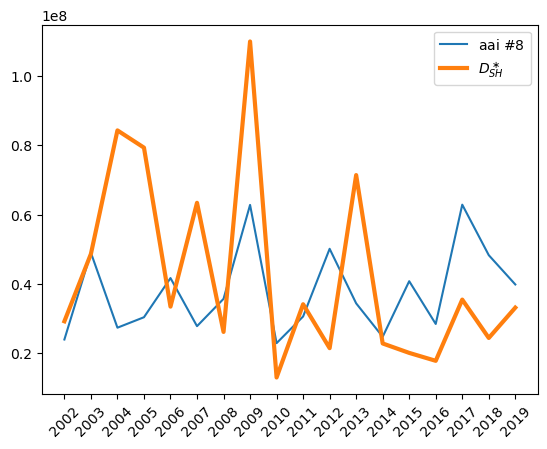

aai_agg = 37800334.617308095
RMSF is 1.8290515114406647
Correlation of the RMSF data for spearman is 0.19091847265221878 with upper limit 0.6068635663572431 and lower limit -0.3071187317738923 with p value of 0.4479306707266415
Correlation of the RMSF data for pearson is 0.20449589705804316 with upper limit 0.6128548689166992 and lower limit -0.2900678264035525 with a p value of 0.415660889611609
RMSF is 3.0074287420399775


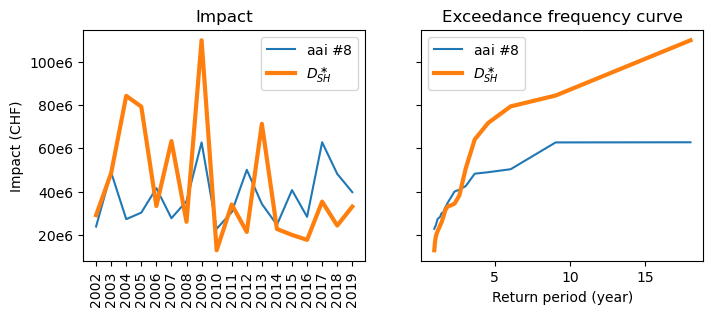

In [42]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

y = np.zeros(120)
y[:] = 0.011
exp_agr["if_HL"]=7
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         7,
                                         0,
                                         0,
                                         0,
                                         y))

imp_agr_RMSF = Impact()
imp_agr_RMSF.calc(exp_agr, ifset_hail, haz_dur, save_mat=True)

#plot
plt.figure()
plt.plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_sturmarchiv, linewidth = 3)
plt.legend([r"aai $\# 8$", r"$D_{SH}^\ast$"])
plt.xticks(rotation = 45)
plt.show()

Y_RMSF = list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())


print("aai_agg = {}".format(imp_agr_RMSF.aai_agg))

print("RMSF is {}".format(fct.RMSF(dmg_from_sturmarchiv, Y_RMSF)))

spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


plt.rcParams['figure.figsize'] = [8, 3]
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0].plot(dmg_from_sturmarchiv, linewidth = 3)
axs[0].legend([r"aai $\# 8$", r"$D_{SH}^\ast$"])
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel("Impact (CHF)")
axs[0].set_yticks(ticks=[20e6, 40e6, 60e6, 80e6, 100e6])
axs[0].set_yticklabels(labels=["20e6", "40e6", "60e6", "80e6", "100e6"])

axs[0].set_title("Impact")

imp_agr_RMSF_year = Impact()
imp_agr_RMSF_year.at_event = np.asarray(list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_agr_RMSF_year.frequency = np.ones(len(imp_agr_RMSF_year.at_event))/len(imp_agr_RMSF_year.at_event)
imp_agr_RMSF_year_freq_curve = imp_agr_RMSF_year.calc_freq_curve(return_per = cp.copy(return_period))

imp_agr_RMSF_year_freq_curve.unit = "CHF"
imp_agr_RMSF_year_freq_curve.plot(axis=axs[1])
imp_sturm_freq_curve.plot(axis = axs[1],linewidth = 3)
axs[1].legend([r"aai $\# 8$", r"$D_{SH}^\ast$"])
axs[1].set_ylabel("")





matplotlib.rcParams.update(matplotlib.rcParamsDefault)


### Dur with lin

In [43]:
#%% Optimization
optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
sector = "agr" # ["infr", "agr"]
optimize_type = "dur" # "" = no optimization, "meshs", "dur"
score_type = "RMSF" #["pearson", "spearman", "RMSF"]
type_imp_fun = "lin" #["sig", "lin", "class", "const"]
norm = False
class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
bound = [(0.1,1),(1.0,150),(0.0,20)]
if optimize_type != "":
    num_fct = 1 #[1:3]
    init_parameter=[]
    if sector == "agr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[1:1+num_fct]
            haz = haz_real
            exp = exp_meshs.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            parameter_optimize = imp_fun_parameter[4:4+num_fct]
            haz = haz_dur
            bounds = num_fct*bound
            exp = exp_dur.copy()
    elif sector=="infr":
        if optimize_type == "meshs":
            parameter_optimize = imp_fun_parameter[0:1+num_fct]
            haz = haz_real
            exp = exp_infr.copy()
            bounds = num_fct*bound

        elif optimize_type == "dur":
            print("NO dur for infr")

    for i in range(num_fct):
        init_parameter += [*parameter_optimize[i].values()][1:4]

    if num_fct == 1:
        exp["if_HL"] = parameter_optimize[0]["imp_id"]
    if type_imp_fun == "lin":
        bounds = [(0.001,0.01)]
        imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
        parameter_optimize = [imp_fun_lin]
        exp.if_HL = 9
    if type_imp_fun == "class":
        bound = [(0,0.001)]
        if class_mult:
            bounds = [slice(0,0.000_051,0.000_01),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2),
                  slice(0,1,0.2)]
        else:
            bounds = [slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,1,1),
                      slice(0,0.01_1,0.000_1)]                
        init_parameter = [0,0,0,0]
        parameter_optimize=init_parameter
    if type_imp_fun == "const":
        parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
        bounds = [slice(0,0.01,0.000_01)]
    args = (parameter_optimize, 
            exp, 
            haz, 
            haz_type, 
            num_fct, 
            score_type, 
            type_imp_fun, 
            sector, 
            norm, 
            class_mult,
            optimize_type)
    # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
    optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
    # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
    # test = fct.make_Y(init_parameter, args)
    print(optimize_results)
    print(score_type)
    print(optimize_type)


    

2021-03-28 20:43:09,900 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:43:09,901 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:43:09,908 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  1.3409477550012525
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 9, 'm': 0.001, 'q': 0}]
The sum of the new Impact is: 5.93e+08
spearman for agr  (score, p_value) = (0.05882352941176471, 0.8166542035684891)
pearson for agr  (score, p_value) = (0.3607626720461297, 0.14135379030023057)
RMSF:  2.0066077429587756
RMSE 780737840153603.9
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-03-28 20:43:11,247 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifti

2021-03-28 20:43:23,104 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.
time to calc impact:  1.6946735569945304
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Params [{'imp_id': 9, 'm': 0.010000000000000002, 'q': 0}]
The sum of the new Impact is: 5.93e+09
spearman for agr  (score, p_value) = (0.05882352941176471, 0.8166542035684891)
pearson for agr  (score, p_value) = (0.36082591646984086, 0.1412789263571486)
RMSF:  9.170386169601834
RMSE 1.1075264976304237e+17
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0.001
RMSF
dur


2021-03-28 20:51:08,579 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-28 20:51:08,586 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-03-28 20:51:08,596 - climada.engine.impact - INFO - Calculating damage for 454826 assets (>0) and 3294 events.


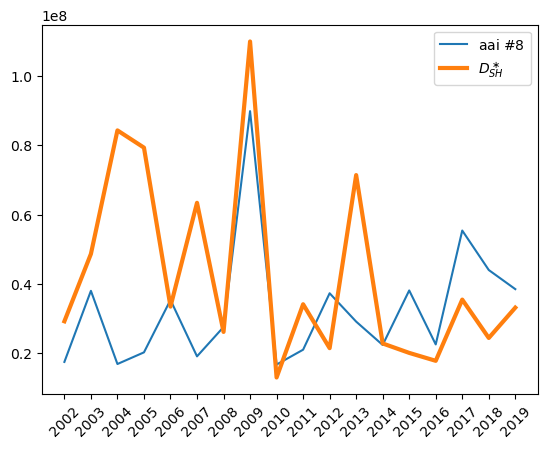

aai_agg = 32673566.197968643
RMSF is 2.011293765807649
Correlation of the RMSF data for spearman is 0.05882352941176471 with upper limit 0.5119653543008154 and lower limit -0.41992963142551154 with p value of 0.8166542035684891
Correlation of the RMSF data for pearson is 0.3607626714766058 with upper limit 0.7083293346658848 and lower limit -0.12759877367613187 with a p value of 0.1413537909745132
RMSF is 3.38577946845708
Correlation of the RMSF data for spearman is 0.05882352941176471 with upper limit 0.5119653543008154 and lower limit -0.41992963142551154 with p value of 0.8166542035684891
Correlation of the RMSF data for pearson is 0.3607626714766058 with upper limit 0.7083293346658848 and lower limit -0.12759877367613187 with a p value of 0.1413537909745132
RMSF is 2.011293765807649
Coefficients: 
 [[0.55155842]]
Mean squared error: 160532082712167.28
Coefficient of determination: 0.48


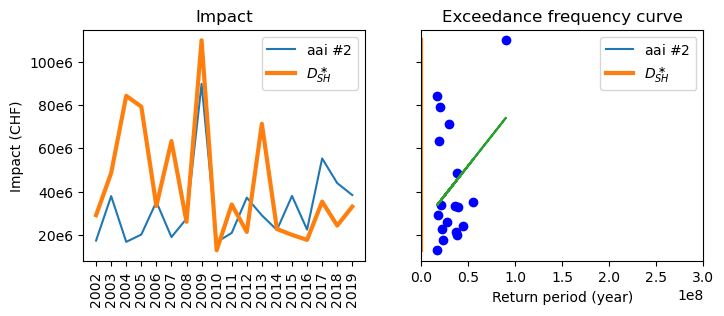

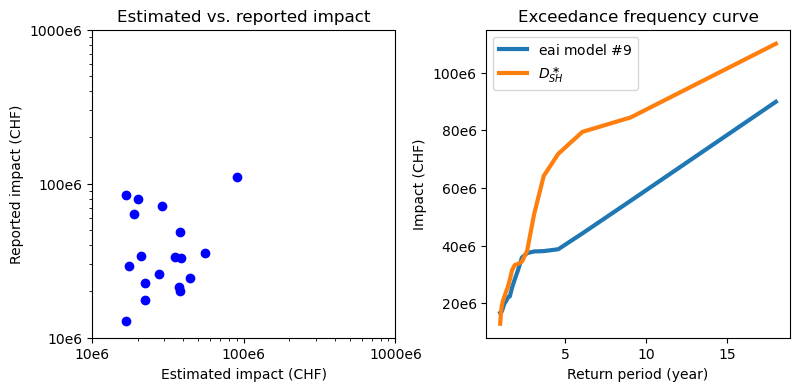

In [50]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

m = 0.001
y = np.zeros(120)
for count, val in enumerate(y):
    y[count] = count*m
exp_agr["if_HL"]=7
ifset_hail = ImpactFuncSet()
ifset_hail.append(fct.create_impact_func(haz_type,
                                         7,
                                         0,
                                         0,
                                         0,
                                         y))

imp_agr_RMSF = Impact()
imp_agr_RMSF.calc(exp_agr, ifset_hail, haz_dur, save_mat=True)

#plot
plt.figure()
plt.plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
plt.plot(dmg_from_sturmarchiv, linewidth = 3)
plt.legend([r"aai $\# 8$", r"$D_{SH}^\ast$"])
plt.xticks(rotation = 45)
plt.show()

Y_RMSF = list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())


print("aai_agg = {}".format(imp_agr_RMSF.aai_agg))

print("RMSF is {}".format(fct.RMSF(dmg_from_sturmarchiv, Y_RMSF)))

spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_vkg, Y_RMSF)))


plt.rcParams['figure.figsize'] = [8, 3]
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(years, list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
axs[0].plot(dmg_from_sturmarchiv, linewidth = 3)
axs[0].legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel("Impact (CHF)")
axs[0].set_yticks(ticks=[20e6, 40e6, 60e6, 80e6, 100e6])
axs[0].set_yticklabels(labels=["20e6", "40e6", "60e6", "80e6", "100e6"])

axs[0].set_title("Impact")

imp_agr_RMSF_year = Impact()
imp_agr_RMSF_year.at_event = np.asarray(list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_agr_RMSF_year.frequency = np.ones(len(imp_agr_RMSF_year.at_event))/len(imp_agr_RMSF_year.at_event)
imp_agr_RMSF_year_freq_curve = imp_agr_RMSF_year.calc_freq_curve(return_per = cp.copy(return_period))

imp_agr_RMSF_year_freq_curve.unit = "CHF"
imp_agr_RMSF_year_freq_curve.plot(axis=axs[1])
imp_sturm_freq_curve.plot(axis = axs[1],linewidth = 3)
axs[1].legend([r"aai $\# 2$", r"$D_{SH}^\ast$"])
axs[1].set_ylabel("")






Y_RMSF = list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values())
spear_coef, spear_p_value, spear_lo, spear_hi = spearmanr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))
pear_coef, pear_p_value, pear_lo, pear_hi = pearsonr_ci(np.array(dmg_from_sturmarchiv), np.array(Y_RMSF))

print("Correlation of the RMSF data for spearman is {} with upper limit {} and lower limit {} with p value of {}".format(spear_coef, spear_hi, spear_lo, spear_p_value))
print("Correlation of the RMSF data for pearson is {} with upper limit {} and lower limit {} with a p value of {}".format(pear_coef, pear_hi, pear_lo, pear_p_value))
print("RMSF is {}".format(fct.RMSF(dmg_from_sturmarchiv, Y_RMSF)))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X = np.zeros((len(Y_RMSF), 1))
for count, i in enumerate(Y_RMSF):
    X[count,0] = i
y = np.zeros((len(dmg_from_sturmarchiv), 1))
for count, i in enumerate(dmg_from_sturmarchiv):
    y[count,0] = i
plt.plot(X, y, "bo")
plt.xlim([0,3e8])
reg = LinearRegression().fit(X, y)
reg.score(X,y)
y_pred = reg.predict(X)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(X, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X, y_pred))
plt.plot(X,y_pred)

plt.rcParams['figure.figsize'] = [9, 4]

X_c7 = cp.copy(X)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, "bo")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xticks([1e7, 1e8, 1e9])
ax[0].set_xticklabels(["10e6", "100e6", "1000e6"])
ax[0].set_yticks([1e7, 1e8, 1e9])
ax[0].set_yticklabels(["10e6", "100e6", "1000e6"])
ax[0].set_ylabel(r"Reported impact (CHF)")
ax[0].set_xlabel("Estimated impact (CHF)")
ax[0].set_title("Estimated vs. reported impact")
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xticks([0, 1e6, 1e7, 1e8], ["test","test","test","test",])

imp_RMSF_year = Impact()
imp_RMSF_year.at_event = np.asarray(list(imp_agr_RMSF.calc_impact_year_set(year_range=[2002,2019]).values()))
imp_RMSF_year.frequency = np.ones(len(imp_agr_RMSF_year.at_event))/len(imp_RMSF_year.at_event)
imp_RMSF_year_freq_curve = imp_agr_RMSF_year.calc_freq_curve(return_per = return_period)
imp_RMSF_year_freq_curve.unit = "CHF"

imp_RMSF_year_freq_curve_c7 = cp.copy(imp_RMSF_year_freq_curve)

imp_RMSF_year_freq_curve.plot(axis=ax[1], linewidth = 3, color = "tab:blue")
imp_sturm_freq_curve.plot(axis=ax[1], linewidth = 3 ,color = "tab:orange")
ax[1].legend([r"eai model $\# 9$", r"$D_{SH}^\ast$"])
ax[1].set_ylabel("Impact (CHF)")
ax[1].set_yticks(ticks=[20e6, 40e6, 60e6, 80e6, 100e6])
ax[1].set_yticklabels(labels=["20e6", "40e6", "60e6", "80e6", "100e6"])

#plt.subplots_adjust(left=None, bottom=None, right=1.7, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.3)

#plt.xlim([0,3e8])
#plt.ylim([0, 3e8])
#plt.xlabel(r"aai $\# 1$")
#plt.ylabel(r"$D_{VKG}^\ast$")
#plt.title("MESHS on Infrastructure")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [ ]:
#Base
#%% Optimization
if False:
    optimize_results = [2.2e-05, 1.8e+00, 0.0e+00, 3.0e-01]
    sector = "infr" # ["infr", "agr"]
    optimize_type = "meshs" # "" = no optimization, "meshs", "dur"
    score_type = "RMSF" #["pearson", "spearman", "RMSF"]
    type_imp_fun = "const" #["sig", "lin", "class", "const"]
    norm = False
    class_mult = False # True -> imp_fun_class_mult False -> imp_fun_class
    bound = [(0.1,1),(1.0,150),(0.0,20)]
    if optimize_type != "":
        num_fct = 1 #[1:3]
        init_parameter=[]
        if sector == "agr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[1:1+num_fct]
                haz = haz_real
                exp = exp_meshs.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                parameter_optimize = imp_fun_parameter[4:4+num_fct]
                haz = haz_dur
                bounds = num_fct*bound
                exp = exp_dur.copy()
        elif sector=="infr":
            if optimize_type == "meshs":
                parameter_optimize = imp_fun_parameter[0:1+num_fct]
                haz = haz_real
                exp = exp_infr.copy()
                bounds = num_fct*bound

            elif optimize_type == "dur":
                print("NO dur for infr")

        for i in range(num_fct):
            init_parameter += [*parameter_optimize[i].values()][1:4]

        if num_fct == 1:
            exp["if_HL"] = parameter_optimize[0]["imp_id"]
        if type_imp_fun == "lin":
            bounds = [(0.01,0.03)]
            imp_fun_lin = {"imp_id": 9, "m": 0.1, "q": 0}
            parameter_optimize = [imp_fun_lin]
            exp.if_HL = 9
        if type_imp_fun == "class":
            bound = [(0,0.001)]
            if class_mult:
                bounds = [slice(0,0.000_051,0.000_01),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2),
                      slice(0,1,0.2)]
            else:
                bounds = [slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,1,1),
                          slice(0,0.01_1,0.000_1)]                
            init_parameter = [0,0,0,0]
            parameter_optimize=init_parameter
        if type_imp_fun == "const":
            parameter_optimize = [{"imp_id": parameter_optimize[0]["imp_id"], "y_const":0}]
            bounds = [slice(0,0.001,0.000_001)]
        args = (parameter_optimize, 
                exp, 
                haz, 
                haz_type, 
                num_fct, 
                score_type, 
                type_imp_fun, 
                sector, 
                norm, 
                class_mult,
                optimize_type)
        # optimize_results = optimize.differential_evolution(func=fct.make_Y, bounds = bounds, args = args, workers = 3)
        optimize_results = optimize.brute(func = fct.make_Y, ranges = bounds, args = args, Ns = 10, full_output=False, finish=None, workers=1)
        # optimize_results = optimize.minimize(fun = fct.make_Y, x0 = init_parameter,method="Powell", args = args, bounds = bounds)
        # test = fct.make_Y(init_parameter, args)
        print(optimize_results)
        print(score_type)
        print(optimize_type)


    y = fct.imp_fun_class(np.arange(150),
                          optimize_results[0],
                          optimize_results[1],
                          optimize_results[2],
                          optimize_results[3],
                          optimize_results[4])
    ifset_hail = ImpactFuncSet()
    ifset_hail.append(fct.create_impact_func(haz_type,
                                             1,
                                             0,
                                             0,
                                             0,
                                             y))
    imp_class = Impact()
    imp_class.calc(exp_infr, ifset_hail, haz_real, save_mat=True)
    print("aai_agg {:.2e}".format(imp_class.aai_agg))
    imp_fun = ifset_hail.get_func()
    print(imp_fun["HL"][1].mdd)
    #plot
    plt.figure()
    plt.plot(years, list(imp_class.calc_impact_year_set(year_range=[2002,2019]).values()))
    plt.plot(dmg_from_vkg, linewidth = 3)
    plt.legend(["class", "vkg"])
    plt.xticks(rotation = 45)
    plt.show()
    print(list(imp_class.calc_impact_year_set(year_range=[2002,2019]).values()))
